In [1]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [22]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)[:3, :, :]
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction


# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [29]:
DATA_PATH = '../data/'
TRAIN_SIZE = 0.9
BATCH_SIZE = 4
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector_resnet101.pt'
OCR_MODEL_PATH = 'ocr_rensenet50.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import BackboneWithFPN, resnet_fpn_backbone

def get_detector_model():
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    model = MaskRCNN(backbone, num_classes = 2)
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

In [5]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='../data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='../data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

In [6]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);


In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|          | 0/5767 [00:00<?, ?it/s]/home/kovalexal/.conda/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
  0%|          | 20/5767 [00:12<53:28,  1.79it/s] 

Loss: 1.4681380


  1%|          | 40/5767 [00:23<55:37,  1.72it/s]  

Loss: 0.6403619


  1%|          | 60/5767 [00:35<54:13,  1.75it/s]  

Loss: 0.5610649


  1%|▏         | 80/5767 [00:47<52:35,  1.80it/s]

Loss: 0.4698387


  2%|▏         | 100/5767 [00:59<57:01,  1.66it/s] 

Loss: 0.3676823


  2%|▏         | 120/5767 [01:11<56:21,  1.67it/s]  

Loss: 0.3278496


  2%|▏         | 140/5767 [01:22<52:04,  1.80it/s]

Loss: 0.3703959


  3%|▎         | 160/5767 [01:33<53:40,  1.74it/s]

Loss: 0.2896550


  3%|▎         | 180/5767 [01:45<53:43,  1.73it/s]

Loss: 0.3182547


  3%|▎         | 200/5767 [01:57<53:51,  1.72it/s]

Loss: 0.2590692


  4%|▍         | 220/5767 [02:08<52:20,  1.77it/s]

Loss: 0.2656980


  4%|▍         | 240/5767 [02:20<54:03,  1.70it/s]

Loss: 0.2700057


  5%|▍         | 260/5767 [02:32<52:55,  1.73it/s]

Loss: 0.2933581


  5%|▍         | 280/5767 [02:44<53:59,  1.69it/s]

Loss: 0.3051791


  5%|▌         | 300/5767 [02:55<54:21,  1.68it/s]

Loss: 0.2603648


  6%|▌         | 320/5767 [03:07<51:32,  1.76it/s]

Loss: 0.2534802


  6%|▌         | 340/5767 [03:19<54:11,  1.67it/s]  

Loss: 0.2408371


  6%|▌         | 360/5767 [03:31<51:52,  1.74it/s]

Loss: 0.2212696


  7%|▋         | 380/5767 [03:43<53:33,  1.68it/s]

Loss: 0.2442632


  7%|▋         | 400/5767 [03:54<54:16,  1.65it/s]

Loss: 0.2439928


  7%|▋         | 420/5767 [04:06<50:08,  1.78it/s]

Loss: 0.2409053


  8%|▊         | 440/5767 [04:18<53:02,  1.67it/s]

Loss: 0.2160821


  8%|▊         | 460/5767 [04:30<50:35,  1.75it/s]

Loss: 0.2106884


  8%|▊         | 480/5767 [04:42<52:10,  1.69it/s]

Loss: 0.2402540


  9%|▊         | 500/5767 [04:54<55:13,  1.59it/s]

Loss: 0.2070183


  9%|▉         | 520/5767 [05:06<56:04,  1.56it/s]

Loss: 0.2127111


  9%|▉         | 540/5767 [05:18<50:13,  1.73it/s]

Loss: 0.2035564


 10%|▉         | 560/5767 [05:30<49:00,  1.77it/s]

Loss: 0.1881444


 10%|█         | 580/5767 [05:41<49:09,  1.76it/s]

Loss: 0.2069171


 10%|█         | 600/5767 [05:54<52:36,  1.64it/s]

Loss: 0.2112627


 11%|█         | 620/5767 [06:05<49:16,  1.74it/s]

Loss: 0.2039800


 11%|█         | 640/5767 [06:18<56:27,  1.51it/s]

Loss: 0.2014002


 11%|█▏        | 660/5767 [06:30<50:47,  1.68it/s]  

Loss: 0.2173371


 12%|█▏        | 680/5767 [06:42<54:16,  1.56it/s]

Loss: 0.2051204


 12%|█▏        | 700/5767 [06:53<49:20,  1.71it/s]

Loss: 0.2056639


 12%|█▏        | 720/5767 [07:06<54:53,  1.53it/s]

Loss: 0.2213892


 13%|█▎        | 740/5767 [07:18<49:38,  1.69it/s]

Loss: 0.2222098


 13%|█▎        | 760/5767 [07:29<50:48,  1.64it/s]

Loss: 0.1957914


 14%|█▎        | 780/5767 [07:41<48:53,  1.70it/s]

Loss: 0.2138780


 14%|█▍        | 800/5767 [07:53<49:21,  1.68it/s]

Loss: 0.1891861


 14%|█▍        | 820/5767 [08:05<48:38,  1.69it/s]

Loss: 0.1952494


 15%|█▍        | 840/5767 [08:17<50:43,  1.62it/s]

Loss: 0.2064754


 15%|█▍        | 860/5767 [08:29<51:44,  1.58it/s]

Loss: 0.2263252


 15%|█▌        | 880/5767 [08:42<48:49,  1.67it/s]

Loss: 0.2786485


 16%|█▌        | 900/5767 [08:53<46:24,  1.75it/s]

Loss: 0.1917138


 16%|█▌        | 920/5767 [09:05<51:24,  1.57it/s]

Loss: 0.2059050


 16%|█▋        | 940/5767 [09:18<50:42,  1.59it/s]

Loss: 0.2022545


 17%|█▋        | 960/5767 [09:30<52:12,  1.53it/s]

Loss: 0.2197364


 17%|█▋        | 980/5767 [09:42<46:03,  1.73it/s]

Loss: 0.2319057
Epoch    49: reducing learning rate of group 0 to 1.5000e-04.


 17%|█▋        | 1000/5767 [09:54<46:18,  1.72it/s]

Loss: 0.1941122


 18%|█▊        | 1020/5767 [10:06<44:55,  1.76it/s]

Loss: 0.1700701


 18%|█▊        | 1040/5767 [10:18<49:48,  1.58it/s]

Loss: 0.1909189


 18%|█▊        | 1060/5767 [10:30<44:52,  1.75it/s]

Loss: 0.2063545


 19%|█▊        | 1080/5767 [10:42<48:10,  1.62it/s]

Loss: 0.1813969


 19%|█▉        | 1100/5767 [10:54<47:36,  1.63it/s]

Loss: 0.1957181


 19%|█▉        | 1120/5767 [11:06<48:09,  1.61it/s]

Loss: 0.1872682


 20%|█▉        | 1140/5767 [11:18<45:55,  1.68it/s]

Loss: 0.2022130


 20%|██        | 1160/5767 [11:30<45:33,  1.69it/s]

Loss: 0.1906679


 20%|██        | 1180/5767 [11:42<46:20,  1.65it/s]

Loss: 0.1925750


 21%|██        | 1200/5767 [11:54<43:00,  1.77it/s]

Loss: 0.1804398


 21%|██        | 1220/5767 [12:07<46:04,  1.64it/s]

Loss: 0.1716750


 22%|██▏       | 1240/5767 [12:19<43:34,  1.73it/s]

Loss: 0.1692640


 22%|██▏       | 1260/5767 [12:31<44:58,  1.67it/s]

Loss: 0.1591303


 22%|██▏       | 1280/5767 [12:43<46:01,  1.62it/s]

Loss: 0.1875055


 23%|██▎       | 1300/5767 [12:55<46:27,  1.60it/s]

Loss: 0.2055638


 23%|██▎       | 1320/5767 [13:07<43:22,  1.71it/s]

Loss: 0.1919960


 23%|██▎       | 1340/5767 [13:19<42:49,  1.72it/s]

Loss: 0.1898809


 24%|██▎       | 1360/5767 [13:31<44:14,  1.66it/s]

Loss: 0.1893701


 24%|██▍       | 1380/5767 [13:43<45:35,  1.60it/s]

Loss: 0.2033764


 24%|██▍       | 1400/5767 [13:55<42:20,  1.72it/s]

Loss: 0.1835961


 25%|██▍       | 1420/5767 [14:07<44:27,  1.63it/s]

Loss: 0.1816301


 25%|██▍       | 1440/5767 [14:19<44:31,  1.62it/s]

Loss: 0.1849464


 25%|██▌       | 1460/5767 [14:31<42:12,  1.70it/s]

Loss: 0.1877035


 26%|██▌       | 1480/5767 [14:43<42:23,  1.69it/s]

Loss: 0.1685752


 26%|██▌       | 1500/5767 [14:55<43:21,  1.64it/s]

Loss: 0.1574450


 26%|██▋       | 1520/5767 [15:07<45:41,  1.55it/s]

Loss: 0.1733076


 27%|██▋       | 1540/5767 [15:19<41:16,  1.71it/s]

Loss: 0.1545042


 27%|██▋       | 1560/5767 [15:31<45:21,  1.55it/s]

Loss: 0.1773206


 27%|██▋       | 1580/5767 [15:43<42:25,  1.64it/s]

Loss: 0.1662694


 28%|██▊       | 1600/5767 [15:55<40:27,  1.72it/s]

Loss: 0.1682296


 28%|██▊       | 1620/5767 [16:07<40:47,  1.69it/s]

Loss: 0.1492249


 28%|██▊       | 1640/5767 [16:19<39:06,  1.76it/s]

Loss: 0.1634246


 29%|██▉       | 1660/5767 [16:32<45:03,  1.52it/s]

Loss: 0.1886326


 29%|██▉       | 1680/5767 [16:43<40:59,  1.66it/s]

Loss: 0.1868738


 29%|██▉       | 1700/5767 [16:55<39:24,  1.72it/s]

Loss: 0.1669736


 30%|██▉       | 1720/5767 [17:07<39:06,  1.72it/s]

Loss: 0.1660083


 30%|███       | 1740/5767 [17:19<40:43,  1.65it/s]

Loss: 0.1668876


 31%|███       | 1760/5767 [17:31<39:17,  1.70it/s]

Loss: 0.1880015


 31%|███       | 1780/5767 [17:43<38:33,  1.72it/s]

Loss: 0.1679858


 31%|███       | 1800/5767 [17:56<40:41,  1.62it/s]

Loss: 0.1636649


 32%|███▏      | 1820/5767 [18:08<41:54,  1.57it/s]

Loss: 0.1706072


 32%|███▏      | 1840/5767 [18:21<40:34,  1.61it/s]

Loss: 0.1750824


 32%|███▏      | 1860/5767 [18:34<41:23,  1.57it/s]

Loss: 0.1770916


 33%|███▎      | 1880/5767 [18:47<38:14,  1.69it/s]

Loss: 0.1864468


 33%|███▎      | 1900/5767 [18:59<39:33,  1.63it/s]

Loss: 0.1796342


 33%|███▎      | 1920/5767 [19:11<36:48,  1.74it/s]

Loss: 0.1581636


 34%|███▎      | 1940/5767 [19:23<35:44,  1.78it/s]

Loss: 0.1693497


 34%|███▍      | 1960/5767 [19:35<37:16,  1.70it/s]

Loss: 0.1733881


 34%|███▍      | 1980/5767 [19:47<37:53,  1.67it/s]

Loss: 0.1968129


 35%|███▍      | 2000/5767 [19:59<37:35,  1.67it/s]

Loss: 0.1905199


 35%|███▌      | 2020/5767 [20:11<36:59,  1.69it/s]

Loss: 0.1807139


 35%|███▌      | 2040/5767 [20:23<38:24,  1.62it/s]

Loss: 0.1787558
Epoch   102: reducing learning rate of group 0 to 7.5000e-05.


 36%|███▌      | 2060/5767 [20:35<34:54,  1.77it/s]

Loss: 0.1540594


 36%|███▌      | 2080/5767 [20:47<37:33,  1.64it/s]

Loss: 0.1856384


 36%|███▋      | 2100/5767 [20:59<40:38,  1.50it/s]

Loss: 0.1581377


 37%|███▋      | 2120/5767 [21:11<36:52,  1.65it/s]

Loss: 0.1571044


 37%|███▋      | 2140/5767 [21:23<37:04,  1.63it/s]

Loss: 0.1610295


 37%|███▋      | 2160/5767 [21:35<35:46,  1.68it/s]

Loss: 0.1800680


 38%|███▊      | 2180/5767 [21:48<37:18,  1.60it/s]

Loss: 0.1580511


 38%|███▊      | 2200/5767 [22:00<35:42,  1.67it/s]

Loss: 0.1724104


 38%|███▊      | 2220/5767 [22:12<36:46,  1.61it/s]

Loss: 0.1893762


 39%|███▉      | 2240/5767 [22:24<37:02,  1.59it/s]

Loss: 0.1620921


 39%|███▉      | 2260/5767 [22:36<34:58,  1.67it/s]

Loss: 0.1675057


 40%|███▉      | 2280/5767 [22:48<35:59,  1.61it/s]

Loss: 0.1871019


 40%|███▉      | 2300/5767 [23:00<34:09,  1.69it/s]

Loss: 0.1760101


 40%|████      | 2320/5767 [23:12<36:13,  1.59it/s]

Loss: 0.1805412


 41%|████      | 2340/5767 [23:25<34:31,  1.65it/s]

Loss: 0.1632056


 41%|████      | 2360/5767 [23:36<34:11,  1.66it/s]

Loss: 0.1590624


 41%|████▏     | 2380/5767 [23:48<34:23,  1.64it/s]

Loss: 0.1665544


 42%|████▏     | 2400/5767 [24:00<33:36,  1.67it/s]

Loss: 0.1766460


 42%|████▏     | 2420/5767 [24:12<32:51,  1.70it/s]

Loss: 0.1689720


 42%|████▏     | 2440/5767 [24:24<31:50,  1.74it/s]

Loss: 0.1640544


 43%|████▎     | 2460/5767 [24:37<33:26,  1.65it/s]

Loss: 0.1626240
Epoch   123: reducing learning rate of group 0 to 3.7500e-05.


 43%|████▎     | 2480/5767 [24:49<33:53,  1.62it/s]

Loss: 0.1821043


 43%|████▎     | 2500/5767 [25:01<31:21,  1.74it/s]

Loss: 0.1975668


 44%|████▎     | 2520/5767 [25:13<32:58,  1.64it/s]

Loss: 0.1550903


 44%|████▍     | 2540/5767 [25:25<33:06,  1.62it/s]

Loss: 0.1605211


 44%|████▍     | 2560/5767 [25:37<34:22,  1.55it/s]

Loss: 0.1563100


 45%|████▍     | 2580/5767 [25:49<32:33,  1.63it/s]

Loss: 0.1983884


 45%|████▌     | 2600/5767 [26:02<31:00,  1.70it/s]

Loss: 0.1627689


 45%|████▌     | 2620/5767 [26:14<35:08,  1.49it/s]

Loss: 0.1752968


 46%|████▌     | 2640/5767 [26:26<31:31,  1.65it/s]

Loss: 0.1819740


 46%|████▌     | 2660/5767 [26:38<30:05,  1.72it/s]

Loss: 0.1934270


 46%|████▋     | 2680/5767 [26:50<30:05,  1.71it/s]

Loss: 0.1635271


 47%|████▋     | 2700/5767 [27:02<29:57,  1.71it/s]

Loss: 0.1399660


 47%|████▋     | 2720/5767 [27:13<29:14,  1.74it/s]

Loss: 0.1643014


 48%|████▊     | 2740/5767 [27:25<31:02,  1.63it/s]

Loss: 0.1696968


 48%|████▊     | 2760/5767 [27:37<29:37,  1.69it/s]

Loss: 0.1573458


 48%|████▊     | 2780/5767 [27:49<31:15,  1.59it/s]

Loss: 0.1527077


 49%|████▊     | 2800/5767 [28:02<30:26,  1.62it/s]

Loss: 0.1776395


 49%|████▉     | 2820/5767 [28:14<29:02,  1.69it/s]

Loss: 0.1609839


 49%|████▉     | 2840/5767 [28:27<30:00,  1.63it/s]

Loss: 0.1677945


 50%|████▉     | 2860/5767 [28:39<31:48,  1.52it/s]

Loss: 0.1439006


 50%|████▉     | 2880/5767 [28:51<28:01,  1.72it/s]

Loss: 0.1457708


 50%|█████     | 2900/5767 [29:03<29:59,  1.59it/s]

Loss: 0.1756612


 51%|█████     | 2920/5767 [29:15<28:55,  1.64it/s]

Loss: 0.1586431


 51%|█████     | 2940/5767 [29:27<28:17,  1.66it/s]

Loss: 0.1613155


 51%|█████▏    | 2960/5767 [29:39<28:19,  1.65it/s]

Loss: 0.1642512


 52%|█████▏    | 2980/5767 [29:51<29:32,  1.57it/s]

Loss: 0.1703527


 52%|█████▏    | 3000/5767 [30:03<27:21,  1.69it/s]

Loss: 0.1558694


 52%|█████▏    | 3020/5767 [30:15<29:32,  1.55it/s]

Loss: 0.1517184


 53%|█████▎    | 3040/5767 [30:28<27:43,  1.64it/s]

Loss: 0.1609678


 53%|█████▎    | 3060/5767 [30:40<27:50,  1.62it/s]

Loss: 0.1492209


 53%|█████▎    | 3080/5767 [30:53<27:45,  1.61it/s]

Loss: 0.1614316


 54%|█████▍    | 3100/5767 [31:05<28:31,  1.56it/s]

Loss: 0.1605647


 54%|█████▍    | 3120/5767 [31:17<26:03,  1.69it/s]

Loss: 0.1570722
Epoch   156: reducing learning rate of group 0 to 1.8750e-05.


 54%|█████▍    | 3140/5767 [31:29<25:34,  1.71it/s]

Loss: 0.1521099


 55%|█████▍    | 3160/5767 [31:40<24:54,  1.74it/s]

Loss: 0.1626303


 55%|█████▌    | 3180/5767 [31:52<24:48,  1.74it/s]

Loss: 0.1695526


 55%|█████▌    | 3200/5767 [32:04<26:22,  1.62it/s]

Loss: 0.1513234


 56%|█████▌    | 3220/5767 [32:16<25:23,  1.67it/s]

Loss: 0.1546068


 56%|█████▌    | 3240/5767 [32:28<28:15,  1.49it/s]

Loss: 0.1751264


 57%|█████▋    | 3260/5767 [32:40<25:39,  1.63it/s]

Loss: 0.1541165


 57%|█████▋    | 3280/5767 [32:52<25:03,  1.65it/s]

Loss: 0.1323078


 57%|█████▋    | 3300/5767 [33:04<24:07,  1.70it/s]

Loss: 0.1509854


 58%|█████▊    | 3320/5767 [33:16<25:02,  1.63it/s]

Loss: 0.1507121


 58%|█████▊    | 3340/5767 [33:28<23:24,  1.73it/s]

Loss: 0.1639169


 58%|█████▊    | 3360/5767 [33:40<22:18,  1.80it/s]

Loss: 0.1532028


 59%|█████▊    | 3380/5767 [33:52<24:20,  1.63it/s]

Loss: 0.1582587


 59%|█████▉    | 3400/5767 [34:05<23:47,  1.66it/s]

Loss: 0.1600339


 59%|█████▉    | 3420/5767 [34:17<23:32,  1.66it/s]

Loss: 0.1535512


 60%|█████▉    | 3440/5767 [34:29<23:13,  1.67it/s]

Loss: 0.1541736


 60%|█████▉    | 3460/5767 [34:41<23:13,  1.66it/s]

Loss: 0.1580653


 60%|██████    | 3480/5767 [34:53<22:22,  1.70it/s]

Loss: 0.1466853


 61%|██████    | 3500/5767 [35:05<21:41,  1.74it/s]

Loss: 0.1689576


 61%|██████    | 3520/5767 [35:17<22:36,  1.66it/s]

Loss: 0.1592942


 61%|██████▏   | 3540/5767 [35:29<22:49,  1.63it/s]

Loss: 0.1460143


 62%|██████▏   | 3560/5767 [35:41<22:30,  1.63it/s]

Loss: 0.1549604


 62%|██████▏   | 3580/5767 [35:53<21:34,  1.69it/s]

Loss: 0.1982298


 62%|██████▏   | 3600/5767 [36:05<21:30,  1.68it/s]

Loss: 0.1480485


 63%|██████▎   | 3620/5767 [36:17<21:23,  1.67it/s]

Loss: 0.1508614


 63%|██████▎   | 3640/5767 [36:29<20:04,  1.77it/s]

Loss: 0.1406504


 63%|██████▎   | 3660/5767 [36:41<21:00,  1.67it/s]

Loss: 0.1625699


 64%|██████▍   | 3680/5767 [36:52<20:00,  1.74it/s]

Loss: 0.1497214


 64%|██████▍   | 3700/5767 [37:04<20:12,  1.70it/s]

Loss: 0.1516974
Epoch   185: reducing learning rate of group 0 to 9.3750e-06.


 65%|██████▍   | 3720/5767 [37:16<20:43,  1.65it/s]

Loss: 0.1692076


 65%|██████▍   | 3740/5767 [37:29<21:00,  1.61it/s]

Loss: 0.1531841


 65%|██████▌   | 3760/5767 [37:41<20:26,  1.64it/s]

Loss: 0.1464001


 66%|██████▌   | 3780/5767 [37:53<20:21,  1.63it/s]

Loss: 0.1685029


 66%|██████▌   | 3800/5767 [38:05<19:59,  1.64it/s]

Loss: 0.1760452


 66%|██████▌   | 3820/5767 [38:17<21:21,  1.52it/s]

Loss: 0.1606693


 67%|██████▋   | 3840/5767 [38:29<19:07,  1.68it/s]

Loss: 0.1711010


 67%|██████▋   | 3860/5767 [38:41<19:05,  1.66it/s]

Loss: 0.1474370


 67%|██████▋   | 3880/5767 [38:53<18:37,  1.69it/s]

Loss: 0.1590463


 68%|██████▊   | 3900/5767 [39:05<19:12,  1.62it/s]

Loss: 0.1477814


 68%|██████▊   | 3920/5767 [39:17<18:15,  1.69it/s]

Loss: 0.1625997


 68%|██████▊   | 3940/5767 [39:30<19:39,  1.55it/s]

Loss: 0.1503092


 69%|██████▊   | 3960/5767 [39:42<17:44,  1.70it/s]

Loss: 0.1501023


 69%|██████▉   | 3980/5767 [39:54<18:36,  1.60it/s]

Loss: 0.1604979


 69%|██████▉   | 4000/5767 [40:06<18:59,  1.55it/s]

Loss: 0.1456808


 70%|██████▉   | 4020/5767 [40:18<17:00,  1.71it/s]

Loss: 0.1543693


 70%|███████   | 4040/5767 [40:30<17:28,  1.65it/s]

Loss: 0.1606536


 70%|███████   | 4060/5767 [40:42<17:00,  1.67it/s]

Loss: 0.1638125


 71%|███████   | 4080/5767 [40:54<17:23,  1.62it/s]

Loss: 0.1728744


 71%|███████   | 4100/5767 [41:06<17:15,  1.61it/s]

Loss: 0.1753519


 71%|███████▏  | 4120/5767 [41:18<17:05,  1.61it/s]

Loss: 0.1694976
Epoch   206: reducing learning rate of group 0 to 4.6875e-06.


 72%|███████▏  | 4140/5767 [41:30<16:16,  1.67it/s]

Loss: 0.1721754


 72%|███████▏  | 4160/5767 [41:43<17:29,  1.53it/s]

Loss: 0.1773448


 72%|███████▏  | 4180/5767 [41:55<16:05,  1.64it/s]

Loss: 0.1611696


 73%|███████▎  | 4200/5767 [42:07<16:46,  1.56it/s]

Loss: 0.1478952


 73%|███████▎  | 4220/5767 [42:19<15:32,  1.66it/s]

Loss: 0.1401407


 74%|███████▎  | 4240/5767 [42:31<14:39,  1.74it/s]

Loss: 0.1592722


 74%|███████▍  | 4260/5767 [42:43<15:09,  1.66it/s]

Loss: 0.1617798


 74%|███████▍  | 4280/5767 [42:55<15:36,  1.59it/s]

Loss: 0.1537927


 75%|███████▍  | 4300/5767 [43:07<13:53,  1.76it/s]

Loss: 0.1779783


 75%|███████▍  | 4320/5767 [43:19<14:36,  1.65it/s]

Loss: 0.1494859


 75%|███████▌  | 4340/5767 [43:31<14:40,  1.62it/s]

Loss: 0.1787956


 76%|███████▌  | 4360/5767 [43:43<13:54,  1.69it/s]

Loss: 0.1427058


 76%|███████▌  | 4380/5767 [43:55<13:16,  1.74it/s]

Loss: 0.1607051


 76%|███████▋  | 4400/5767 [44:08<14:15,  1.60it/s]

Loss: 0.1462238


 77%|███████▋  | 4420/5767 [44:20<14:35,  1.54it/s]

Loss: 0.1626224


 77%|███████▋  | 4440/5767 [44:32<12:54,  1.71it/s]

Loss: 0.1489538


 77%|███████▋  | 4460/5767 [44:44<12:44,  1.71it/s]

Loss: 0.1516699


 78%|███████▊  | 4480/5767 [44:56<12:26,  1.72it/s]

Loss: 0.1442472


 78%|███████▊  | 4500/5767 [45:08<12:42,  1.66it/s]

Loss: 0.1601069


 78%|███████▊  | 4520/5767 [45:20<12:42,  1.64it/s]

Loss: 0.1518219


 79%|███████▊  | 4540/5767 [45:32<11:47,  1.73it/s]

Loss: 0.1585497
Epoch   227: reducing learning rate of group 0 to 2.3437e-06.


 79%|███████▉  | 4560/5767 [45:44<11:57,  1.68it/s]

Loss: 0.1431738


 79%|███████▉  | 4580/5767 [45:57<12:37,  1.57it/s]

Loss: 0.1539769


 80%|███████▉  | 4600/5767 [46:09<12:53,  1.51it/s]

Loss: 0.1493388


 80%|████████  | 4620/5767 [46:22<11:17,  1.69it/s]

Loss: 0.1585543


 80%|████████  | 4640/5767 [46:34<10:56,  1.72it/s]

Loss: 0.1707593


 81%|████████  | 4660/5767 [46:45<10:46,  1.71it/s]

Loss: 0.1631291


 81%|████████  | 4680/5767 [46:58<11:10,  1.62it/s]

Loss: 0.1828641


 81%|████████▏ | 4700/5767 [47:09<10:41,  1.66it/s]

Loss: 0.1504437


 82%|████████▏ | 4720/5767 [47:22<10:43,  1.63it/s]

Loss: 0.1604332


 82%|████████▏ | 4740/5767 [47:34<09:56,  1.72it/s]

Loss: 0.1624500


 83%|████████▎ | 4760/5767 [47:46<10:10,  1.65it/s]

Loss: 0.1606968


 83%|████████▎ | 4780/5767 [47:58<09:39,  1.70it/s]

Loss: 0.1571451


 83%|████████▎ | 4800/5767 [48:10<09:11,  1.75it/s]

Loss: 0.1742110


 84%|████████▎ | 4820/5767 [48:22<09:16,  1.70it/s]

Loss: 0.1560008


 84%|████████▍ | 4840/5767 [48:34<09:17,  1.66it/s]

Loss: 0.1759091


 84%|████████▍ | 4860/5767 [48:46<09:27,  1.60it/s]

Loss: 0.1825736


 85%|████████▍ | 4880/5767 [48:58<09:12,  1.60it/s]

Loss: 0.1545296


 85%|████████▍ | 4900/5767 [49:10<08:30,  1.70it/s]

Loss: 0.1365644


 85%|████████▌ | 4920/5767 [49:22<08:25,  1.68it/s]

Loss: 0.1520020


 86%|████████▌ | 4940/5767 [49:34<08:33,  1.61it/s]

Loss: 0.1620912


 86%|████████▌ | 4960/5767 [49:46<08:02,  1.67it/s]

Loss: 0.1496027
Epoch   248: reducing learning rate of group 0 to 1.1719e-06.


 86%|████████▋ | 4980/5767 [49:58<08:14,  1.59it/s]

Loss: 0.1500014


 87%|████████▋ | 5000/5767 [50:10<07:32,  1.70it/s]

Loss: 0.1519500


 87%|████████▋ | 5020/5767 [50:22<07:25,  1.68it/s]

Loss: 0.1555838


 87%|████████▋ | 5040/5767 [50:34<07:12,  1.68it/s]

Loss: 0.1560008


 88%|████████▊ | 5060/5767 [50:46<07:15,  1.62it/s]

Loss: 0.1398221


 88%|████████▊ | 5080/5767 [50:58<06:58,  1.64it/s]

Loss: 0.1734626


 88%|████████▊ | 5100/5767 [51:10<06:30,  1.71it/s]

Loss: 0.1496494


 89%|████████▉ | 5120/5767 [51:22<06:15,  1.72it/s]

Loss: 0.1519401


 89%|████████▉ | 5140/5767 [51:34<06:10,  1.69it/s]

Loss: 0.1507140


 89%|████████▉ | 5160/5767 [51:46<06:26,  1.57it/s]

Loss: 0.1404853


 90%|████████▉ | 5180/5767 [51:58<05:57,  1.64it/s]

Loss: 0.1503229


 90%|█████████ | 5200/5767 [52:10<05:34,  1.70it/s]

Loss: 0.1619173


 91%|█████████ | 5220/5767 [52:22<05:30,  1.66it/s]

Loss: 0.1603991


 91%|█████████ | 5240/5767 [52:34<05:01,  1.75it/s]

Loss: 0.1429995


 91%|█████████ | 5260/5767 [52:46<05:22,  1.57it/s]

Loss: 0.1685328


 92%|█████████▏| 5280/5767 [52:58<04:55,  1.65it/s]

Loss: 0.1652276


 92%|█████████▏| 5300/5767 [53:11<04:35,  1.70it/s]

Loss: 0.1616816


 92%|█████████▏| 5320/5767 [53:23<04:19,  1.72it/s]

Loss: 0.1565889


 93%|█████████▎| 5340/5767 [53:35<04:20,  1.64it/s]

Loss: 0.1770700


 93%|█████████▎| 5360/5767 [53:47<04:00,  1.69it/s]

Loss: 0.1569733


 93%|█████████▎| 5380/5767 [53:59<03:49,  1.69it/s]

Loss: 0.1670182
Epoch   269: reducing learning rate of group 0 to 5.8594e-07.


 94%|█████████▎| 5400/5767 [54:11<03:43,  1.64it/s]

Loss: 0.1530941


 94%|█████████▍| 5420/5767 [54:22<03:17,  1.76it/s]

Loss: 0.1525232


 94%|█████████▍| 5440/5767 [54:34<03:22,  1.61it/s]

Loss: 0.1563051


 95%|█████████▍| 5460/5767 [54:46<03:01,  1.69it/s]

Loss: 0.1483164


 95%|█████████▌| 5480/5767 [54:58<02:43,  1.75it/s]

Loss: 0.1490556


 95%|█████████▌| 5500/5767 [55:10<02:36,  1.70it/s]

Loss: 0.1401741


 96%|█████████▌| 5520/5767 [55:22<02:30,  1.64it/s]

Loss: 0.1640300


 96%|█████████▌| 5540/5767 [55:35<02:13,  1.70it/s]

Loss: 0.1656268


 96%|█████████▋| 5560/5767 [55:47<02:02,  1.69it/s]

Loss: 0.1499871


 97%|█████████▋| 5580/5767 [55:58<01:46,  1.76it/s]

Loss: 0.1470191


 97%|█████████▋| 5600/5767 [56:10<01:45,  1.58it/s]

Loss: 0.1566641


 97%|█████████▋| 5620/5767 [56:23<01:29,  1.65it/s]

Loss: 0.1722052


 98%|█████████▊| 5640/5767 [56:35<01:13,  1.72it/s]

Loss: 0.1435926


 98%|█████████▊| 5660/5767 [56:46<01:01,  1.74it/s]

Loss: 0.1518422


 98%|█████████▊| 5680/5767 [56:59<00:53,  1.62it/s]

Loss: 0.1688137


 99%|█████████▉| 5700/5767 [57:11<00:39,  1.68it/s]

Loss: 0.1674480


 99%|█████████▉| 5720/5767 [57:23<00:28,  1.67it/s]

Loss: 0.1608986


100%|█████████▉| 5740/5767 [57:35<00:15,  1.70it/s]

Loss: 0.1755159


100%|█████████▉| 5760/5767 [57:48<00:04,  1.58it/s]

Loss: 0.1510382


In [31]:
torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [7]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

../data/test/2661.jpg
Class: plate, Confidence: 0.999697208404541
Bounding box:


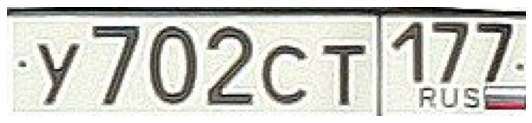

Rotated img:


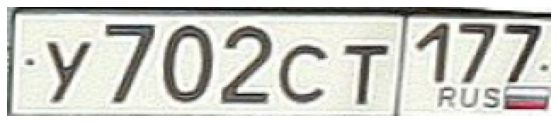

Class: plate, Confidence: 0.9735441207885742
Bounding box:


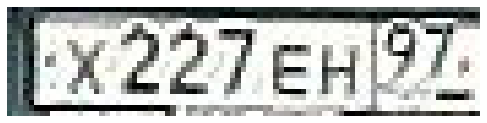

Rotated img:


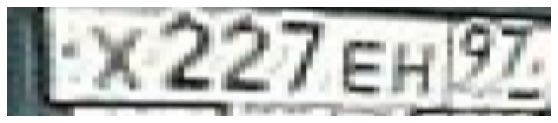

Class: plate, Confidence: 0.8598943948745728
Bounding box:


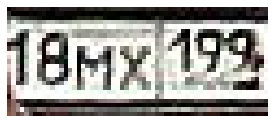

Rotated img:


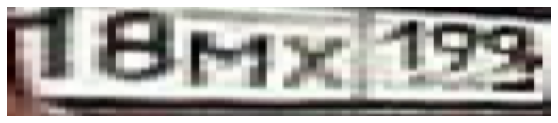

Class: plate, Confidence: 0.7313454747200012
Bounding box:


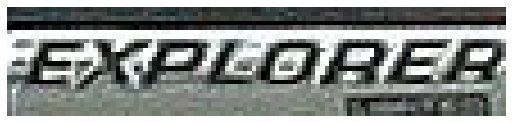

Rotated img:


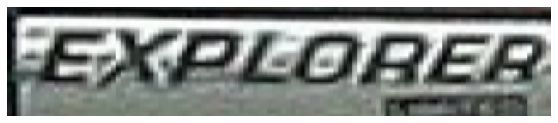

Class: plate, Confidence: 0.5045792460441589
Bounding box:


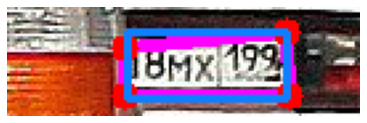

Rotated img:


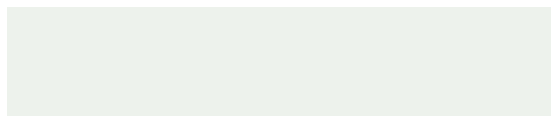

Class: plate, Confidence: 0.10310152173042297
Bounding box:


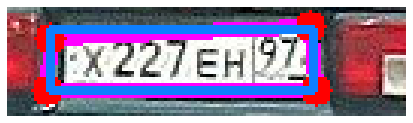

Rotated img:


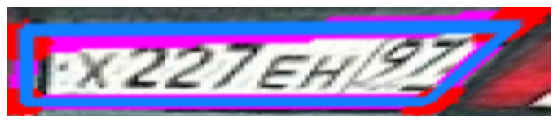

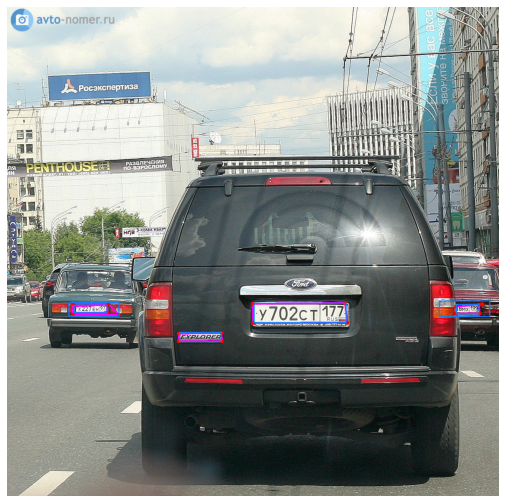

{'boxes': tensor([[ 652.6346,  784.6501,  895.2002,  835.9819],
         [ 177.1403,  789.3599,  264.1009,  809.3205],
         [1186.2363,  787.3261, 1246.4927,  812.0242],
         [ 455.4614,  861.9373,  565.7438,  885.1167],
         [1141.1350,  778.2321, 1274.3962,  819.6727],
         [ 163.9591,  782.4633,  295.8488,  818.1874],
         [ 307.2840,  400.0070,  396.9177,  436.8212]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9997, 0.9735, 0.8599, 0.7313, 0.5046, 0.1031, 0.0841],
        device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
        

In [252]:


# img = np.random.choice(test_images)
img = '../data/test/2661.jpg'
print(img)
visualize_prediction_plate(img, model, id_to_name={1: 'plate'}, thresh=0.1)
# visualize_prediction_plate('../data/test/2661.jpg', model, id_to_name={1: 'plate'}, thresh=0.5)



In [250]:
# THRESHOLD_SCORE = 0.7
# TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):
# for file in tqdm.tqdm(['../data/test/1541.jpg'], position=0, leave=False):
    
    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        # В разных версиях opencv этот метод возвращает разное число параметров
        contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
        approx = simplify_contour(contours[0], n_corners=4)

        if approx is None:
            x0, y0 = x_min, y_min
            x1, y1 = x_max, y_min
            x2, y2 = x_min, y_max
            x3, y3 = x_max, y_max
        else:
            x0, y0 = approx[0][0][0], approx[0][0][1]
            x1, y1 = approx[1][0][0], approx[1][0][1]
            x2, y2 = approx[2][0][0], approx[2][0][1]
            x3, y3 = approx[3][0][0], approx[3][0][1]

        points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

        pred['nums'].append({
            'box': points,
            'bbox': [x_min, y_min, x_max, y_max],
            'score': score
        })
        
    # Попробуем сделать адаптивный порог
    pred['nums'] = sorted(pred['nums'], key=lambda x: x['score'])
    
    # Считаем адаптивный порог кривым образом
    diff, threshold = 0.05, pred['nums'][-1]['score']
    for i in range(len(pred['nums']) - 2, -1, -1):
        current_score = pred['nums'][i]['score']
        current_diff = threshold - current_score
        
        if current_diff > diff:
            break
        else:
            diff = current_diff
            threshold = current_score
        
    # Берем все, что выше порога
    pred['nums'] = list(filter(lambda x: x['score'] >= threshold, pred['nums']))

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test_04_0.7_adaptive_threshold.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

  0%|          | 7/3188 [00:00<05:54,  8.96it/s]

simplify_contour didnt coverege


  1%|          | 16/3188 [00:01<05:36,  9.42it/s]

simplify_contour didnt coverege


  1%|          | 19/3188 [00:02<05:46,  9.15it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


  1%|▏         | 40/3188 [00:04<06:10,  8.50it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


  2%|▏         | 54/3188 [00:05<05:31,  9.46it/s]

simplify_contour didnt coverege


  2%|▏         | 57/3188 [00:06<06:09,  8.47it/s]

simplify_contour didnt coverege


  2%|▏         | 67/3188 [00:07<06:22,  8.15it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


  3%|▎         | 87/3188 [00:09<05:50,  8.85it/s]

simplify_contour didnt coverege


  3%|▎         | 92/3188 [00:10<05:27,  9.45it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


  3%|▎         | 97/3188 [00:10<05:30,  9.36it/s]

simplify_contour didnt coverege


  3%|▎         | 110/3188 [00:12<05:08,  9.97it/s]

simplify_contour didnt coverege


  4%|▍         | 132/3188 [00:14<05:24,  9.42it/s]

simplify_contour didnt coverege


  5%|▍         | 146/3188 [00:16<05:45,  8.80it/s]

simplify_contour didnt coverege


  5%|▌         | 167/3188 [00:18<05:24,  9.30it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


  5%|▌         | 172/3188 [00:19<05:27,  9.22it/s]

simplify_contour didnt coverege


  6%|▋         | 203/3188 [00:22<05:11,  9.59it/s]

simplify_contour didnt coverege


  6%|▋         | 207/3188 [00:22<05:52,  8.47it/s]

simplify_contour didnt coverege


  7%|▋         | 226/3188 [00:24<05:13,  9.46it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


  8%|▊         | 244/3188 [00:26<05:59,  8.19it/s]

simplify_contour didnt coverege


  8%|▊         | 248/3188 [00:27<06:43,  7.28it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


  8%|▊         | 254/3188 [00:28<06:12,  7.89it/s]

simplify_contour didnt coverege


  8%|▊         | 262/3188 [00:29<05:41,  8.58it/s]

simplify_contour didnt coverege


  8%|▊         | 269/3188 [00:29<05:35,  8.69it/s]

simplify_contour didnt coverege


  9%|▊         | 271/3188 [00:30<05:25,  8.96it/s]

simplify_contour didnt coverege


  9%|▊         | 275/3188 [00:30<05:39,  8.58it/s]

simplify_contour didnt coverege


  9%|▉         | 279/3188 [00:31<05:51,  8.29it/s]

simplify_contour didnt coverege


  9%|▉         | 281/3188 [00:31<06:08,  7.89it/s]

simplify_contour didnt coverege


  9%|▉         | 298/3188 [00:33<05:52,  8.20it/s]

simplify_contour didnt coverege


 10%|▉         | 307/3188 [00:34<05:31,  8.69it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 10%|▉         | 309/3188 [00:34<05:35,  8.59it/s]

simplify_contour didnt coverege


 10%|▉         | 312/3188 [00:35<05:12,  9.20it/s]

simplify_contour didnt coverege


 10%|█         | 320/3188 [00:36<05:43,  8.35it/s]

simplify_contour didnt coverege


 10%|█         | 323/3188 [00:36<05:33,  8.58it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 10%|█         | 333/3188 [00:37<04:47,  9.92it/s]

simplify_contour didnt coverege


 11%|█         | 337/3188 [00:37<05:07,  9.27it/s]

simplify_contour didnt coverege


 11%|█         | 343/3188 [00:38<06:23,  7.41it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 11%|█         | 354/3188 [00:40<05:22,  8.77it/s]

simplify_contour didnt coverege


 11%|█▏        | 363/3188 [00:40<04:49,  9.76it/s]

simplify_contour didnt coverege


 12%|█▏        | 377/3188 [00:42<04:59,  9.38it/s]

simplify_contour didnt coverege


 12%|█▏        | 383/3188 [00:43<05:10,  9.04it/s]

simplify_contour didnt coverege


 12%|█▏        | 385/3188 [00:43<05:08,  9.08it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 13%|█▎        | 400/3188 [00:45<05:48,  8.01it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 13%|█▎        | 407/3188 [00:46<05:35,  8.29it/s]

simplify_contour didnt coverege


 13%|█▎        | 425/3188 [00:48<05:56,  7.75it/s]

simplify_contour didnt coverege


 14%|█▎        | 432/3188 [00:49<05:41,  8.06it/s]

simplify_contour didnt coverege


 14%|█▍        | 447/3188 [00:50<05:03,  9.03it/s]

simplify_contour didnt coverege


 14%|█▍        | 450/3188 [00:51<05:05,  8.97it/s]

simplify_contour didnt coverege


 14%|█▍        | 453/3188 [00:51<05:12,  8.76it/s]

simplify_contour didnt coverege


 15%|█▍        | 474/3188 [00:53<05:57,  7.60it/s]

simplify_contour didnt coverege


 15%|█▌        | 480/3188 [00:54<05:01,  8.99it/s]

simplify_contour didnt coverege


 15%|█▌        | 488/3188 [00:55<05:11,  8.67it/s]

simplify_contour didnt coverege


 16%|█▌        | 495/3188 [00:56<04:50,  9.26it/s]

simplify_contour didnt coverege


 16%|█▌        | 508/3188 [00:57<05:06,  8.76it/s]

simplify_contour didnt coverege


 16%|█▌        | 514/3188 [00:58<05:00,  8.89it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 16%|█▋        | 526/3188 [00:59<04:55,  9.01it/s]

simplify_contour didnt coverege


 17%|█▋        | 541/3188 [01:01<04:53,  9.02it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 17%|█▋        | 547/3188 [01:01<05:22,  8.18it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 18%|█▊        | 578/3188 [01:05<04:16, 10.19it/s]

simplify_contour didnt coverege


 20%|█▉        | 626/3188 [01:10<05:04,  8.43it/s]

simplify_contour didnt coverege


 20%|█▉        | 630/3188 [01:11<06:23,  6.67it/s]

simplify_contour didnt coverege


 21%|██        | 657/3188 [01:14<05:04,  8.31it/s]

simplify_contour didnt coverege


 21%|██        | 664/3188 [01:15<05:38,  7.46it/s]

simplify_contour didnt coverege


 21%|██        | 670/3188 [01:16<04:48,  8.74it/s]

simplify_contour didnt coverege


 21%|██        | 675/3188 [01:16<04:55,  8.50it/s]

simplify_contour didnt coverege


 22%|██▏       | 687/3188 [01:17<04:42,  8.85it/s]

simplify_contour didnt coverege


 22%|██▏       | 699/3188 [01:19<05:12,  7.97it/s]

simplify_contour didnt coverege


 22%|██▏       | 707/3188 [01:20<05:15,  7.85it/s]

simplify_contour didnt coverege


 23%|██▎       | 719/3188 [01:21<04:18,  9.56it/s]

simplify_contour didnt coverege


 23%|██▎       | 734/3188 [01:23<03:48, 10.75it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 23%|██▎       | 738/3188 [01:23<04:31,  9.03it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 23%|██▎       | 747/3188 [01:24<04:12,  9.67it/s]

simplify_contour didnt coverege


 24%|██▎       | 755/3188 [01:25<04:38,  8.74it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 24%|██▍       | 774/3188 [01:27<04:45,  8.45it/s]

simplify_contour didnt coverege


 24%|██▍       | 777/3188 [01:27<04:41,  8.58it/s]

simplify_contour didnt coverege


 25%|██▍       | 785/3188 [01:28<04:33,  8.78it/s]

simplify_contour didnt coverege


 25%|██▍       | 789/3188 [01:29<04:20,  9.22it/s]

simplify_contour didnt coverege


 25%|██▌       | 798/3188 [01:30<04:43,  8.43it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 26%|██▌       | 831/3188 [01:34<04:50,  8.12it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 26%|██▋       | 841/3188 [01:35<04:33,  8.57it/s]

simplify_contour didnt coverege


 27%|██▋       | 851/3188 [01:36<04:23,  8.87it/s]

simplify_contour didnt coverege


 28%|██▊       | 883/3188 [01:39<04:27,  8.62it/s]

simplify_contour didnt coverege


 28%|██▊       | 905/3188 [01:41<03:45, 10.12it/s]

simplify_contour didnt coverege


 29%|██▊       | 910/3188 [01:42<04:04,  9.31it/s]

simplify_contour didnt coverege


 29%|██▊       | 912/3188 [01:42<04:34,  8.30it/s]

simplify_contour didnt coverege


 29%|██▉       | 924/3188 [01:44<04:15,  8.88it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 29%|██▉       | 927/3188 [01:44<04:18,  8.74it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 29%|██▉       | 934/3188 [01:45<03:54,  9.62it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 30%|██▉       | 941/3188 [01:45<03:52,  9.66it/s]

simplify_contour didnt coverege


 30%|██▉       | 944/3188 [01:46<04:18,  8.67it/s]

simplify_contour didnt coverege


 30%|██▉       | 947/3188 [01:46<05:21,  6.96it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 30%|███       | 961/3188 [01:48<04:09,  8.92it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 30%|███       | 963/3188 [01:48<04:17,  8.63it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 30%|███       | 971/3188 [01:49<04:13,  8.74it/s]

simplify_contour didnt coverege


 31%|███       | 973/3188 [01:49<04:10,  8.85it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 31%|███       | 986/3188 [01:51<04:22,  8.40it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 32%|███▏      | 1016/3188 [01:54<04:04,  8.89it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 32%|███▏      | 1021/3188 [01:55<03:55,  9.21it/s]

simplify_contour didnt coverege


 33%|███▎      | 1039/3188 [01:57<03:50,  9.34it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 33%|███▎      | 1041/3188 [01:57<04:23,  8.14it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 33%|███▎      | 1045/3188 [01:57<04:21,  8.21it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 33%|███▎      | 1050/3188 [01:58<04:02,  8.81it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 33%|███▎      | 1051/3188 [01:58<04:18,  8.26it/s]

simplify_contour didnt coverege


 33%|███▎      | 1058/3188 [01:59<04:21,  8.14it/s]

simplify_contour didnt coverege


 33%|███▎      | 1060/3188 [01:59<04:28,  7.94it/s]

simplify_contour didnt coverege


 33%|███▎      | 1066/3188 [02:00<04:08,  8.53it/s]

simplify_contour didnt coverege


 34%|███▎      | 1070/3188 [02:00<04:24,  8.02it/s]

simplify_contour didnt coverege


 34%|███▍      | 1076/3188 [02:01<05:03,  6.96it/s]

simplify_contour didnt coverege


 35%|███▌      | 1118/3188 [02:06<04:39,  7.40it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 35%|███▌      | 1120/3188 [02:06<04:11,  8.22it/s]

simplify_contour didnt coverege


 35%|███▌      | 1127/3188 [02:07<04:09,  8.26it/s]

simplify_contour didnt coverege


 36%|███▌      | 1132/3188 [02:08<03:47,  9.04it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 36%|███▌      | 1142/3188 [02:09<04:03,  8.39it/s]

simplify_contour didnt coverege


 36%|███▌      | 1152/3188 [02:10<04:36,  7.35it/s]

simplify_contour didnt coverege


 36%|███▋      | 1162/3188 [02:11<03:54,  8.63it/s]

simplify_contour didnt coverege


 37%|███▋      | 1168/3188 [02:12<03:42,  9.07it/s]

simplify_contour didnt coverege


 37%|███▋      | 1178/3188 [02:13<03:43,  9.01it/s]

simplify_contour didnt coverege


 37%|███▋      | 1184/3188 [02:14<04:01,  8.31it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 37%|███▋      | 1194/3188 [02:15<03:46,  8.80it/s]

simplify_contour didnt coverege


 38%|███▊      | 1215/3188 [02:17<03:40,  8.96it/s]

simplify_contour didnt coverege


 38%|███▊      | 1220/3188 [02:18<04:11,  7.81it/s]

simplify_contour didnt coverege


 39%|███▉      | 1244/3188 [02:21<03:31,  9.21it/s]

simplify_contour didnt coverege


 39%|███▉      | 1251/3188 [02:22<04:04,  7.92it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 40%|███▉      | 1273/3188 [02:24<03:10, 10.06it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 40%|████      | 1289/3188 [02:26<03:57,  8.00it/s]

simplify_contour didnt coverege


 41%|████      | 1295/3188 [02:27<04:21,  7.23it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 41%|████      | 1304/3188 [02:28<03:47,  8.29it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 41%|████      | 1308/3188 [02:28<03:26,  9.10it/s]

simplify_contour didnt coverege


 41%|████▏     | 1316/3188 [02:29<03:26,  9.08it/s]

simplify_contour didnt coverege


 42%|████▏     | 1324/3188 [02:30<03:46,  8.22it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 42%|████▏     | 1329/3188 [02:30<03:24,  9.10it/s]

simplify_contour didnt coverege


 42%|████▏     | 1344/3188 [02:32<03:37,  8.47it/s]

simplify_contour didnt coverege


 43%|████▎     | 1372/3188 [02:35<03:34,  8.46it/s]

simplify_contour didnt coverege


 44%|████▍     | 1402/3188 [02:39<03:29,  8.53it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 45%|████▍     | 1430/3188 [02:42<03:10,  9.22it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 45%|████▍     | 1433/3188 [02:42<03:06,  9.40it/s]

simplify_contour didnt coverege


 46%|████▌     | 1452/3188 [02:44<03:21,  8.60it/s]

simplify_contour didnt coverege


 46%|████▌     | 1468/3188 [02:46<03:27,  8.30it/s]

simplify_contour didnt coverege


 47%|████▋     | 1492/3188 [02:49<03:18,  8.53it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 47%|████▋     | 1513/3188 [02:51<02:52,  9.70it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 48%|████▊     | 1516/3188 [02:51<03:14,  8.61it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 48%|████▊     | 1531/3188 [02:53<03:47,  7.29it/s]

simplify_contour didnt coverege


 48%|████▊     | 1537/3188 [02:54<03:10,  8.66it/s]

simplify_contour didnt coverege


 49%|████▉     | 1565/3188 [02:57<03:20,  8.08it/s]

simplify_contour didnt coverege


 49%|████▉     | 1569/3188 [02:57<03:21,  8.03it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 50%|████▉     | 1591/3188 [03:00<03:03,  8.71it/s]

simplify_contour didnt coverege


 50%|█████     | 1604/3188 [03:01<02:56,  8.99it/s]

simplify_contour didnt coverege


 51%|█████     | 1610/3188 [03:02<03:26,  7.63it/s]

simplify_contour didnt coverege


 51%|█████     | 1616/3188 [03:03<02:49,  9.30it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 51%|█████     | 1618/3188 [03:03<03:02,  8.58it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 51%|█████     | 1625/3188 [03:04<02:53,  9.01it/s]

simplify_contour didnt coverege


 52%|█████▏    | 1644/3188 [03:06<02:51,  9.00it/s]

simplify_contour didnt coverege


 52%|█████▏    | 1654/3188 [03:07<02:44,  9.31it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 52%|█████▏    | 1669/3188 [03:09<02:59,  8.46it/s]

simplify_contour didnt coverege


 53%|█████▎    | 1698/3188 [03:12<02:51,  8.67it/s]

simplify_contour didnt coverege


 54%|█████▎    | 1708/3188 [03:13<02:47,  8.81it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 54%|█████▍    | 1716/3188 [03:14<02:29,  9.84it/s]

simplify_contour didnt coverege


 54%|█████▍    | 1722/3188 [03:14<02:34,  9.46it/s]

simplify_contour didnt coverege


 54%|█████▍    | 1726/3188 [03:15<02:34,  9.47it/s]

simplify_contour didnt coverege


 54%|█████▍    | 1737/3188 [03:16<02:56,  8.21it/s]

simplify_contour didnt coverege


 55%|█████▍    | 1748/3188 [03:17<03:02,  7.88it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 55%|█████▌    | 1755/3188 [03:18<02:43,  8.77it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 55%|█████▌    | 1762/3188 [03:19<02:41,  8.85it/s]

simplify_contour didnt coverege


 55%|█████▌    | 1768/3188 [03:20<02:43,  8.68it/s]

simplify_contour didnt coverege


 56%|█████▌    | 1771/3188 [03:20<02:50,  8.31it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 56%|█████▌    | 1785/3188 [03:22<02:36,  8.96it/s]

simplify_contour didnt coverege


 56%|█████▌    | 1791/3188 [03:22<02:35,  8.99it/s]

simplify_contour didnt coverege


 57%|█████▋    | 1816/3188 [03:25<02:28,  9.26it/s]

simplify_contour didnt coverege


 58%|█████▊    | 1844/3188 [03:28<03:03,  7.32it/s]

simplify_contour didnt coverege


 58%|█████▊    | 1848/3188 [03:29<02:33,  8.70it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 58%|█████▊    | 1850/3188 [03:29<02:32,  8.76it/s]

simplify_contour didnt coverege


 58%|█████▊    | 1853/3188 [03:29<02:38,  8.44it/s]

simplify_contour didnt coverege


 58%|█████▊    | 1859/3188 [03:30<02:22,  9.33it/s]

simplify_contour didnt coverege


 59%|█████▉    | 1878/3188 [03:32<02:19,  9.36it/s]

simplify_contour didnt coverege


 59%|█████▉    | 1882/3188 [03:32<02:29,  8.71it/s]

simplify_contour didnt coverege


 60%|█████▉    | 1903/3188 [03:35<02:21,  9.08it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 60%|█████▉    | 1905/3188 [03:35<02:25,  8.82it/s]

simplify_contour didnt coverege


 60%|██████    | 1914/3188 [03:36<02:34,  8.27it/s]

simplify_contour didnt coverege


 60%|██████    | 1923/3188 [03:37<02:25,  8.68it/s]

simplify_contour didnt coverege


 61%|██████    | 1943/3188 [03:39<02:14,  9.25it/s]

simplify_contour didnt coverege


 61%|██████    | 1952/3188 [03:40<02:26,  8.41it/s]

simplify_contour didnt coverege


 62%|██████▏   | 1982/3188 [03:44<02:11,  9.20it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 62%|██████▏   | 1992/3188 [03:45<02:13,  8.94it/s]

simplify_contour didnt coverege


 63%|██████▎   | 2001/3188 [03:46<02:13,  8.90it/s]

simplify_contour didnt coverege


 64%|██████▍   | 2043/3188 [03:51<02:18,  8.24it/s]

simplify_contour didnt coverege


 65%|██████▌   | 2082/3188 [03:55<01:59,  9.24it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 65%|██████▌   | 2088/3188 [03:56<02:08,  8.53it/s]

simplify_contour didnt coverege


 66%|██████▌   | 2098/3188 [03:57<02:11,  8.31it/s]

simplify_contour didnt coverege


 66%|██████▌   | 2102/3188 [03:58<02:33,  7.08it/s]

simplify_contour didnt coverege


 66%|██████▌   | 2105/3188 [03:58<02:31,  7.14it/s]

simplify_contour didnt coverege


 66%|██████▌   | 2111/3188 [03:59<01:59,  8.98it/s]

simplify_contour didnt coverege


 66%|██████▋   | 2120/3188 [04:00<01:51,  9.54it/s]

simplify_contour didnt coverege


 67%|██████▋   | 2126/3188 [04:00<01:53,  9.32it/s]

simplify_contour didnt coverege


 67%|██████▋   | 2131/3188 [04:01<02:08,  8.22it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 67%|██████▋   | 2134/3188 [04:01<02:07,  8.24it/s]

simplify_contour didnt coverege


 67%|██████▋   | 2136/3188 [04:02<02:01,  8.63it/s]

simplify_contour didnt coverege


 67%|██████▋   | 2139/3188 [04:02<01:58,  8.82it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 68%|██████▊   | 2160/3188 [04:04<01:44,  9.82it/s]

simplify_contour didnt coverege


 68%|██████▊   | 2181/3188 [04:06<02:01,  8.30it/s]

simplify_contour didnt coverege


 69%|██████▊   | 2188/3188 [04:07<01:52,  8.87it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 69%|██████▉   | 2193/3188 [04:08<01:48,  9.19it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 70%|██████▉   | 2222/3188 [04:11<01:38,  9.76it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 70%|███████   | 2238/3188 [04:13<01:54,  8.28it/s]

simplify_contour didnt coverege


 70%|███████   | 2244/3188 [04:13<01:56,  8.12it/s]

simplify_contour didnt coverege


 71%|███████   | 2251/3188 [04:14<01:41,  9.25it/s]

simplify_contour didnt coverege


 71%|███████▏  | 2277/3188 [04:17<01:40,  9.03it/s]

simplify_contour didnt coverege


 72%|███████▏  | 2284/3188 [04:18<01:43,  8.72it/s]

simplify_contour didnt coverege


 72%|███████▏  | 2311/3188 [04:21<01:43,  8.47it/s]

simplify_contour didnt coverege


 73%|███████▎  | 2338/3188 [04:24<01:33,  9.08it/s]

simplify_contour didnt coverege


 74%|███████▎  | 2351/3188 [04:26<01:31,  9.11it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 74%|███████▍  | 2354/3188 [04:26<01:35,  8.71it/s]

simplify_contour didnt coverege


 74%|███████▍  | 2364/3188 [04:27<01:32,  8.94it/s]

simplify_contour didnt coverege


 75%|███████▍  | 2379/3188 [04:29<01:33,  8.66it/s]

simplify_contour didnt coverege


 75%|███████▍  | 2387/3188 [04:30<01:46,  7.55it/s]

simplify_contour didnt coverege


 75%|███████▌  | 2398/3188 [04:31<01:36,  8.18it/s]

simplify_contour didnt coverege


 76%|███████▌  | 2417/3188 [04:33<01:17,  9.95it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 76%|███████▌  | 2422/3188 [04:34<01:22,  9.33it/s]

simplify_contour didnt coverege


 76%|███████▌  | 2428/3188 [04:35<01:28,  8.63it/s]

simplify_contour didnt coverege


 76%|███████▋  | 2432/3188 [04:35<01:32,  8.14it/s]

simplify_contour didnt coverege


 77%|███████▋  | 2442/3188 [04:36<01:21,  9.10it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 77%|███████▋  | 2455/3188 [04:38<01:28,  8.24it/s]

simplify_contour didnt coverege


 78%|███████▊  | 2479/3188 [04:40<01:22,  8.64it/s]

simplify_contour didnt coverege


 78%|███████▊  | 2483/3188 [04:41<01:24,  8.36it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 78%|███████▊  | 2488/3188 [04:41<01:17,  8.99it/s]

simplify_contour didnt coverege


 78%|███████▊  | 2496/3188 [04:42<01:20,  8.58it/s]

simplify_contour didnt coverege


 79%|███████▉  | 2529/3188 [04:46<01:07,  9.71it/s]

simplify_contour didnt coverege


 79%|███████▉  | 2532/3188 [04:46<01:23,  7.86it/s]

simplify_contour didnt coverege


 80%|███████▉  | 2536/3188 [04:47<01:13,  8.89it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 80%|███████▉  | 2546/3188 [04:48<01:18,  8.22it/s]

simplify_contour didnt coverege


 81%|████████  | 2571/3188 [04:51<01:04,  9.60it/s]

simplify_contour didnt coverege


 81%|████████  | 2580/3188 [04:52<01:08,  8.86it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 81%|████████  | 2583/3188 [04:52<01:09,  8.65it/s]

simplify_contour didnt coverege


 83%|████████▎ | 2634/3188 [04:58<01:07,  8.20it/s]

simplify_contour didnt coverege


 83%|████████▎ | 2648/3188 [04:59<01:02,  8.70it/s]

simplify_contour didnt coverege


 84%|████████▎ | 2666/3188 [05:02<00:59,  8.75it/s]

simplify_contour didnt coverege


 84%|████████▍ | 2670/3188 [05:02<00:57,  8.96it/s]

simplify_contour didnt coverege


 84%|████████▍ | 2674/3188 [05:02<00:59,  8.62it/s]

simplify_contour didnt coverege


 84%|████████▍ | 2677/3188 [05:03<00:59,  8.60it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 84%|████████▍ | 2680/3188 [05:03<00:58,  8.75it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 84%|████████▍ | 2686/3188 [05:04<00:56,  8.87it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 84%|████████▍ | 2689/3188 [05:04<00:56,  8.76it/s]

simplify_contour didnt coverege


 84%|████████▍ | 2690/3188 [05:04<00:55,  9.00it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 85%|████████▍ | 2694/3188 [05:05<00:53,  9.29it/s]

simplify_contour didnt coverege


 85%|████████▌ | 2718/3188 [05:08<00:53,  8.85it/s]

simplify_contour didnt coverege


 86%|████████▌ | 2729/3188 [05:09<00:52,  8.77it/s]

simplify_contour didnt coverege


 86%|████████▌ | 2736/3188 [05:10<00:59,  7.65it/s]

simplify_contour didnt coverege


 86%|████████▌ | 2744/3188 [05:11<00:48,  9.18it/s]

simplify_contour didnt coverege


 86%|████████▌ | 2746/3188 [05:11<00:49,  8.86it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 87%|████████▋ | 2760/3188 [05:12<00:44,  9.59it/s]

simplify_contour didnt coverege


 87%|████████▋ | 2768/3188 [05:13<00:53,  7.84it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 87%|████████▋ | 2771/3188 [05:14<00:51,  8.12it/s]

simplify_contour didnt coverege


 87%|████████▋ | 2778/3188 [05:14<00:47,  8.64it/s]

simplify_contour didnt coverege


 87%|████████▋ | 2789/3188 [05:16<00:58,  6.83it/s]

simplify_contour didnt coverege


 88%|████████▊ | 2799/3188 [05:17<00:46,  8.37it/s]

simplify_contour didnt coverege


 88%|████████▊ | 2814/3188 [05:19<00:40,  9.17it/s]

simplify_contour didnt coverege


 89%|████████▉ | 2832/3188 [05:20<00:37,  9.49it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 89%|████████▉ | 2836/3188 [05:21<00:41,  8.55it/s]

simplify_contour didnt coverege


 89%|████████▉ | 2842/3188 [05:22<00:42,  8.08it/s]

simplify_contour didnt coverege


 89%|████████▉ | 2849/3188 [05:23<00:42,  7.95it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 90%|████████▉ | 2859/3188 [05:24<00:40,  8.22it/s]

simplify_contour didnt coverege


 90%|█████████ | 2874/3188 [05:26<00:37,  8.28it/s]

simplify_contour didnt coverege


 90%|█████████ | 2878/3188 [05:26<00:35,  8.77it/s]

simplify_contour didnt coverege


 90%|█████████ | 2882/3188 [05:26<00:33,  9.23it/s]

simplify_contour didnt coverege


 91%|█████████ | 2892/3188 [05:28<00:35,  8.26it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 91%|█████████▏| 2912/3188 [05:30<00:37,  7.38it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 92%|█████████▏| 2929/3188 [05:32<00:27,  9.42it/s]

simplify_contour didnt coverege


 92%|█████████▏| 2938/3188 [05:33<00:27,  9.03it/s]

simplify_contour didnt coverege


 92%|█████████▏| 2941/3188 [05:33<00:28,  8.74it/s]

simplify_contour didnt coverege


 93%|█████████▎| 2966/3188 [05:36<00:26,  8.34it/s]

simplify_contour didnt coverege


 93%|█████████▎| 2978/3188 [05:38<00:29,  7.14it/s]

simplify_contour didnt coverege


 94%|█████████▎| 2982/3188 [05:38<00:27,  7.38it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 94%|█████████▎| 2984/3188 [05:38<00:25,  8.03it/s]

simplify_contour didnt coverege


 94%|█████████▎| 2986/3188 [05:39<00:25,  8.07it/s]

simplify_contour didnt coverege


 94%|█████████▍| 2989/3188 [05:39<00:23,  8.59it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


 94%|█████████▍| 3006/3188 [05:41<00:26,  6.78it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 95%|█████████▌| 3033/3188 [05:44<00:16,  9.19it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 96%|█████████▌| 3052/3188 [05:46<00:15,  8.83it/s]

simplify_contour didnt coverege


 96%|█████████▌| 3057/3188 [05:47<00:15,  8.64it/s]

simplify_contour didnt coverege


 96%|█████████▋| 3069/3188 [05:48<00:14,  8.20it/s]

simplify_contour didnt coverege


 96%|█████████▋| 3071/3188 [05:48<00:14,  8.27it/s]

simplify_contour didnt coverege
simplify_contour didnt coverege


 97%|█████████▋| 3101/3188 [05:52<00:09,  9.06it/s]

simplify_contour didnt coverege


 99%|█████████▊| 3141/3188 [05:56<00:05,  8.74it/s]

simplify_contour didnt coverege


 99%|█████████▊| 3143/3188 [05:56<00:05,  8.99it/s]

simplify_contour didnt coverege


 99%|█████████▉| 3159/3188 [05:58<00:03,  9.03it/s]

simplify_contour didnt coverege


 99%|█████████▉| 3162/3188 [05:58<00:02,  9.17it/s]

simplify_contour didnt coverege


simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege
simplify_contour didnt coverege


In [49]:
THRESHOLD_SCORE = 0.7
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE: 
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test_04_0.7.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

 10%|▉         | 309/3188 [00:34<05:27,  8.78it/s]

simplify_contour didnt coverege


 30%|██▉       | 941/3188 [01:45<03:46,  9.91it/s]

simplify_contour didnt coverege


 41%|████      | 1308/3188 [02:28<03:23,  9.24it/s]

simplify_contour didnt coverege


 49%|████▉     | 1569/3188 [02:58<03:27,  7.81it/s]

simplify_contour didnt coverege


 67%|██████▋   | 2137/3188 [04:04<01:56,  9.02it/s]

simplify_contour didnt coverege


 74%|███████▎  | 2351/3188 [04:29<01:32,  9.04it/s]

simplify_contour didnt coverege


 89%|████████▉ | 2836/3188 [05:24<00:40,  8.61it/s]

simplify_contour didnt coverege


 94%|█████████▍| 3006/3188 [05:43<00:26,  6.95it/s]

simplify_contour didnt coverege


 99%|█████████▉| 3159/3188 [06:00<00:03,  9.11it/s]

simplify_contour didnt coverege


In [50]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(520, 115)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(520, 115)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

7

In [40]:
import math

class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(115, 520), output_len=32):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet50')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(math.ceil(h / 32), 1))        
        self.proj = nn.Conv2d(math.ceil(w / 32), output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn3.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(115, 520), 
        cnn_output_len=32,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=True
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [41]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

In [42]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [43]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  1%|          | 20/3016 [00:06<17:11,  2.91it/s]

Loss: 5.4067791


  1%|▏         | 40/3016 [00:13<18:36,  2.67it/s]

Loss: 3.4417156


  2%|▏         | 60/3016 [00:20<18:44,  2.63it/s]

Loss: 3.2928717


  3%|▎         | 80/3016 [00:27<18:11,  2.69it/s]

Loss: 3.2282848


  3%|▎         | 100/3016 [00:34<15:47,  3.08it/s]

Loss: 3.1675068


  4%|▍         | 120/3016 [00:41<15:51,  3.04it/s]

Loss: 3.0497206


  5%|▍         | 140/3016 [00:48<17:12,  2.79it/s]

Loss: 2.9491457


  5%|▌         | 160/3016 [00:55<17:32,  2.71it/s]

Loss: 2.8598159


  6%|▌         | 180/3016 [01:02<16:37,  2.84it/s]

Loss: 2.7700805


  7%|▋         | 200/3016 [01:09<17:02,  2.75it/s]

Loss: 2.6824265


  7%|▋         | 220/3016 [01:16<17:20,  2.69it/s]

Loss: 2.5817278


  8%|▊         | 240/3016 [01:23<17:42,  2.61it/s]

Loss: 2.4495593


  9%|▊         | 260/3016 [01:30<16:37,  2.76it/s]

Loss: 2.3664953


  9%|▉         | 280/3016 [01:37<13:55,  3.28it/s]

Loss: 2.1436976


 10%|▉         | 300/3016 [01:44<15:41,  2.89it/s]

Loss: 2.0090548


 11%|█         | 320/3016 [01:51<15:16,  2.94it/s]

Loss: 1.7802063


 11%|█▏        | 340/3016 [01:58<14:45,  3.02it/s]

Loss: 1.5966799


 12%|█▏        | 360/3016 [02:05<15:13,  2.91it/s]

Loss: 1.4519315


 13%|█▎        | 380/3016 [02:12<14:08,  3.11it/s]

Loss: 1.3667381


 13%|█▎        | 400/3016 [02:18<15:23,  2.83it/s]

Loss: 1.3080661


 14%|█▍        | 420/3016 [02:25<14:48,  2.92it/s]

Loss: 1.2846703


 15%|█▍        | 440/3016 [02:32<14:13,  3.02it/s]

Loss: 1.2571643


 15%|█▌        | 460/3016 [02:39<14:09,  3.01it/s]

Loss: 1.2371589


 16%|█▌        | 480/3016 [02:46<14:46,  2.86it/s]

Loss: 1.1875372


 17%|█▋        | 500/3016 [02:53<15:03,  2.79it/s]

Loss: 1.1799841


 17%|█▋        | 520/3016 [03:00<15:01,  2.77it/s]

Loss: 1.1813931


 18%|█▊        | 540/3016 [03:07<14:37,  2.82it/s]

Loss: 1.1205576


 19%|█▊        | 560/3016 [03:13<13:56,  2.93it/s]

Loss: 1.0864583


 19%|█▉        | 580/3016 [03:20<14:35,  2.78it/s]

Loss: 1.0134272


 20%|█▉        | 600/3016 [03:27<15:23,  2.62it/s]

Loss: 1.0224176


 21%|██        | 620/3016 [03:34<13:37,  2.93it/s]

Loss: 1.0004782


 21%|██        | 640/3016 [03:41<14:10,  2.79it/s]

Loss: 0.9898855


 22%|██▏       | 660/3016 [03:48<14:42,  2.67it/s]

Loss: 0.9778135


 23%|██▎       | 680/3016 [03:55<13:20,  2.92it/s]

Loss: 0.9063651


 23%|██▎       | 700/3016 [04:02<14:26,  2.67it/s]

Loss: 0.9154861


 24%|██▍       | 720/3016 [04:09<13:09,  2.91it/s]

Loss: 0.8883853


 25%|██▍       | 740/3016 [04:16<13:43,  2.76it/s]

Loss: 0.8640842


 25%|██▌       | 760/3016 [04:22<12:30,  3.01it/s]

Loss: 0.8394509


 26%|██▌       | 780/3016 [04:29<11:57,  3.12it/s]

Loss: 0.8322192


 27%|██▋       | 800/3016 [04:36<12:59,  2.84it/s]

Loss: 0.7861156


 27%|██▋       | 820/3016 [04:43<13:01,  2.81it/s]

Loss: 0.7619079


 28%|██▊       | 840/3016 [04:50<13:38,  2.66it/s]

Loss: 0.7522553


 29%|██▊       | 860/3016 [04:57<12:53,  2.79it/s]

Loss: 0.7691518


 29%|██▉       | 880/3016 [05:04<11:43,  3.04it/s]

Loss: 0.7058099


 30%|██▉       | 900/3016 [05:11<13:38,  2.58it/s]

Loss: 0.6766023


 31%|███       | 920/3016 [05:18<12:02,  2.90it/s]

Loss: 0.6801415


 31%|███       | 940/3016 [05:25<11:49,  2.93it/s]

Loss: 0.6784952


 32%|███▏      | 960/3016 [05:32<11:13,  3.05it/s]

Loss: 0.6046698


 32%|███▏      | 980/3016 [05:39<11:11,  3.03it/s]

Loss: 0.6099851


 33%|███▎      | 1000/3016 [05:46<12:18,  2.73it/s]

Loss: 0.5770181


 34%|███▍      | 1020/3016 [05:52<10:41,  3.11it/s]

Loss: 0.5827771


 34%|███▍      | 1040/3016 [05:59<11:49,  2.78it/s]

Loss: 0.5344897


 35%|███▌      | 1060/3016 [06:06<10:46,  3.03it/s]

Loss: 0.4873449


 36%|███▌      | 1080/3016 [06:13<11:32,  2.80it/s]

Loss: 0.5162814


 36%|███▋      | 1100/3016 [06:19<11:10,  2.86it/s]

Loss: 0.4423343


 37%|███▋      | 1120/3016 [06:26<10:53,  2.90it/s]

Loss: 0.4274182


 38%|███▊      | 1140/3016 [06:33<12:04,  2.59it/s]

Loss: 0.4542255


 38%|███▊      | 1160/3016 [06:40<11:25,  2.71it/s]

Loss: 0.4150279


 39%|███▉      | 1180/3016 [06:47<10:40,  2.87it/s]

Loss: 0.4091723


 40%|███▉      | 1200/3016 [06:54<10:13,  2.96it/s]

Loss: 0.3296320


 40%|████      | 1220/3016 [07:01<10:19,  2.90it/s]

Loss: 0.3923849


 41%|████      | 1240/3016 [07:07<10:09,  2.92it/s]

Loss: 0.3559859


 42%|████▏     | 1260/3016 [07:14<10:59,  2.66it/s]

Loss: 0.3597946


 42%|████▏     | 1280/3016 [07:21<10:07,  2.86it/s]

Loss: 0.3501933


 43%|████▎     | 1300/3016 [07:28<09:46,  2.93it/s]

Loss: 0.3150950


 44%|████▍     | 1320/3016 [07:35<10:24,  2.72it/s]

Loss: 0.3050368


 44%|████▍     | 1340/3016 [07:42<09:21,  2.98it/s]

Loss: 0.2662414


 45%|████▌     | 1360/3016 [07:49<09:08,  3.02it/s]

Loss: 0.2339765


 46%|████▌     | 1380/3016 [07:55<07:58,  3.42it/s]

Loss: 0.2352552


 46%|████▋     | 1400/3016 [08:02<08:44,  3.08it/s]

Loss: 0.2028063


 47%|████▋     | 1420/3016 [08:09<08:38,  3.08it/s]

Loss: 0.2399895


 48%|████▊     | 1440/3016 [08:16<09:36,  2.73it/s]

Loss: 0.2737832


 48%|████▊     | 1460/3016 [08:23<08:45,  2.96it/s]

Loss: 0.2203988


 49%|████▉     | 1480/3016 [08:29<07:38,  3.35it/s]

Loss: 0.2429648


 50%|████▉     | 1500/3016 [08:36<09:01,  2.80it/s]

Loss: 0.1714365


 50%|█████     | 1520/3016 [08:42<07:43,  3.23it/s]

Loss: 0.2386603


 51%|█████     | 1540/3016 [08:49<08:06,  3.03it/s]

Loss: 0.2074209


 52%|█████▏    | 1560/3016 [08:56<08:09,  2.97it/s]

Loss: 0.2384757


 52%|█████▏    | 1580/3016 [09:03<08:07,  2.95it/s]

Loss: 0.2358792


 53%|█████▎    | 1600/3016 [09:10<08:11,  2.88it/s]

Loss: 0.1903656


 54%|█████▎    | 1620/3016 [09:17<07:48,  2.98it/s]

Loss: 0.2331262


 54%|█████▍    | 1640/3016 [09:23<07:07,  3.22it/s]

Loss: 0.2024681


 55%|█████▌    | 1660/3016 [09:30<07:18,  3.09it/s]

Loss: 0.1996116


 56%|█████▌    | 1680/3016 [09:36<07:39,  2.91it/s]

Loss: 0.1546683


 56%|█████▋    | 1700/3016 [09:43<07:08,  3.07it/s]

Loss: 0.2099786


 57%|█████▋    | 1720/3016 [09:50<07:23,  2.92it/s]

Loss: 0.1355115


 58%|█████▊    | 1740/3016 [09:57<07:06,  3.00it/s]

Loss: 0.1508585


 58%|█████▊    | 1760/3016 [10:03<06:48,  3.07it/s]

Loss: 0.2385749


 59%|█████▉    | 1780/3016 [10:10<06:27,  3.19it/s]

Loss: 0.2232377


 60%|█████▉    | 1800/3016 [10:17<07:39,  2.65it/s]

Loss: 0.2203557


 60%|██████    | 1820/3016 [10:24<07:03,  2.82it/s]

Loss: 0.1953267


 61%|██████    | 1840/3016 [10:30<06:26,  3.04it/s]

Loss: 0.1554631


 62%|██████▏   | 1860/3016 [10:37<06:26,  2.99it/s]

Loss: 0.1681075


 62%|██████▏   | 1880/3016 [10:44<06:02,  3.14it/s]

Loss: 0.1483812


 63%|██████▎   | 1900/3016 [10:51<06:14,  2.98it/s]

Loss: 0.1595734


 64%|██████▎   | 1920/3016 [10:58<06:22,  2.86it/s]

Loss: 0.1859452


 64%|██████▍   | 1940/3016 [11:04<06:06,  2.94it/s]

Loss: 0.1774129
Epoch    97: reducing learning rate of group 0 to 1.5000e-04.


 65%|██████▍   | 1960/3016 [11:11<06:11,  2.84it/s]

Loss: 0.1975958


 66%|██████▌   | 1980/3016 [11:18<05:41,  3.03it/s]

Loss: 0.1635752


 66%|██████▋   | 2000/3016 [11:25<05:58,  2.84it/s]

Loss: 0.1623019


 67%|██████▋   | 2020/3016 [11:32<05:56,  2.79it/s]

Loss: 0.1428992


 68%|██████▊   | 2040/3016 [11:39<05:50,  2.79it/s]

Loss: 0.1419446


 68%|██████▊   | 2060/3016 [11:45<05:19,  2.99it/s]

Loss: 0.1463916


 69%|██████▉   | 2080/3016 [11:52<05:50,  2.67it/s]

Loss: 0.1328507


 70%|██████▉   | 2100/3016 [11:59<04:54,  3.11it/s]

Loss: 0.1825414


 70%|███████   | 2120/3016 [12:06<04:41,  3.18it/s]

Loss: 0.1321799


 71%|███████   | 2140/3016 [12:13<05:00,  2.92it/s]

Loss: 0.1210242


 72%|███████▏  | 2160/3016 [12:20<05:02,  2.83it/s]

Loss: 0.1354204


 72%|███████▏  | 2180/3016 [12:27<04:17,  3.25it/s]

Loss: 0.1595734


 73%|███████▎  | 2200/3016 [12:34<04:47,  2.84it/s]

Loss: 0.1395130


 74%|███████▎  | 2220/3016 [12:41<04:33,  2.91it/s]

Loss: 0.1369714


 74%|███████▍  | 2240/3016 [12:47<04:27,  2.90it/s]

Loss: 0.1443740


 75%|███████▍  | 2260/3016 [12:54<04:04,  3.09it/s]

Loss: 0.1246577


 76%|███████▌  | 2280/3016 [13:01<04:55,  2.49it/s]

Loss: 0.1446289


 76%|███████▋  | 2300/3016 [13:08<03:27,  3.46it/s]

Loss: 0.1394339


 77%|███████▋  | 2320/3016 [13:14<03:58,  2.92it/s]

Loss: 0.1411866


 78%|███████▊  | 2340/3016 [13:21<03:46,  2.98it/s]

Loss: 0.1444594


 78%|███████▊  | 2360/3016 [13:28<03:43,  2.93it/s]

Loss: 0.1220300
Epoch   118: reducing learning rate of group 0 to 7.5000e-05.


 79%|███████▉  | 2380/3016 [13:35<03:53,  2.73it/s]

Loss: 0.1584766


 80%|███████▉  | 2400/3016 [13:41<03:24,  3.02it/s]

Loss: 0.1487106


 80%|████████  | 2420/3016 [13:48<03:22,  2.94it/s]

Loss: 0.1293496


 81%|████████  | 2440/3016 [13:55<03:09,  3.03it/s]

Loss: 0.1510546


 82%|████████▏ | 2460/3016 [14:02<03:13,  2.87it/s]

Loss: 0.1754898


 82%|████████▏ | 2480/3016 [14:09<03:02,  2.94it/s]

Loss: 0.1304503


 83%|████████▎ | 2500/3016 [14:16<03:09,  2.73it/s]

Loss: 0.1549744


 84%|████████▎ | 2520/3016 [14:22<02:41,  3.08it/s]

Loss: 0.1056284


 84%|████████▍ | 2540/3016 [14:29<02:37,  3.03it/s]

Loss: 0.1247040


 85%|████████▍ | 2560/3016 [14:36<02:21,  3.23it/s]

Loss: 0.1505905


 86%|████████▌ | 2580/3016 [14:43<02:27,  2.96it/s]

Loss: 0.1449865


 86%|████████▌ | 2600/3016 [14:50<02:20,  2.96it/s]

Loss: 0.1211286


 87%|████████▋ | 2620/3016 [14:56<02:17,  2.88it/s]

Loss: 0.1705784


 88%|████████▊ | 2640/3016 [15:03<02:04,  3.02it/s]

Loss: 0.1533532


 88%|████████▊ | 2660/3016 [15:10<02:08,  2.77it/s]

Loss: 0.1452181


 89%|████████▉ | 2680/3016 [15:17<01:55,  2.92it/s]

Loss: 0.1197982


 90%|████████▉ | 2700/3016 [15:24<01:43,  3.05it/s]

Loss: 0.1136577


 90%|█████████ | 2720/3016 [15:31<01:39,  2.96it/s]

Loss: 0.1511164


 91%|█████████ | 2740/3016 [15:38<01:34,  2.91it/s]

Loss: 0.1384737
Epoch   137: reducing learning rate of group 0 to 3.7500e-05.


 92%|█████████▏| 2760/3016 [15:44<01:25,  3.00it/s]

Loss: 0.1333998


 92%|█████████▏| 2780/3016 [15:51<01:19,  2.98it/s]

Loss: 0.1583902


 93%|█████████▎| 2800/3016 [15:58<01:06,  3.25it/s]

Loss: 0.1207398


 94%|█████████▎| 2820/3016 [16:04<01:07,  2.89it/s]

Loss: 0.1469112


 94%|█████████▍| 2840/3016 [16:11<00:56,  3.13it/s]

Loss: 0.1045509


 95%|█████████▍| 2860/3016 [16:18<00:51,  3.06it/s]

Loss: 0.1613831


 95%|█████████▌| 2880/3016 [16:25<00:46,  2.93it/s]

Loss: 0.1025884


 96%|█████████▌| 2900/3016 [16:32<00:38,  3.03it/s]

Loss: 0.1085653


 97%|█████████▋| 2920/3016 [16:39<00:36,  2.65it/s]

Loss: 0.1099339


 97%|█████████▋| 2940/3016 [16:46<00:27,  2.77it/s]

Loss: 0.1371336


 98%|█████████▊| 2960/3016 [16:53<00:18,  3.03it/s]

Loss: 0.1012418


 99%|█████████▉| 2980/3016 [17:00<00:12,  2.78it/s]

Loss: 0.1500942


 99%|█████████▉| 3000/3016 [17:06<00:05,  3.05it/s]

Loss: 0.1245843


  0%|          | 0/3016 [00:00<?, ?it/s]           

3015 0.6622038190870667


  1%|          | 20/3016 [00:07<17:08,  2.91it/s]

Loss: 0.1028704


  1%|▏         | 40/3016 [00:13<16:56,  2.93it/s]

Loss: 0.1165759


  2%|▏         | 60/3016 [00:20<17:41,  2.78it/s]

Loss: 0.1295174


  3%|▎         | 80/3016 [00:27<17:03,  2.87it/s]

Loss: 0.1132282


  3%|▎         | 100/3016 [00:34<15:57,  3.05it/s]

Loss: 0.1019539


  4%|▍         | 120/3016 [00:41<17:04,  2.83it/s]

Loss: 0.1269713


  5%|▍         | 140/3016 [00:48<17:53,  2.68it/s]

Loss: 0.1249754


  5%|▌         | 160/3016 [00:55<18:11,  2.62it/s]

Loss: 0.1270749


  6%|▌         | 180/3016 [01:02<16:02,  2.95it/s]

Loss: 0.1538440
Epoch   159: reducing learning rate of group 0 to 1.8750e-05.


  7%|▋         | 200/3016 [01:09<16:41,  2.81it/s]

Loss: 0.1398866


  7%|▋         | 220/3016 [01:16<15:32,  3.00it/s]

Loss: 0.1032800


  8%|▊         | 240/3016 [01:23<16:41,  2.77it/s]

Loss: 0.1239324


  9%|▊         | 260/3016 [01:30<14:55,  3.08it/s]

Loss: 0.1282489


  9%|▉         | 280/3016 [01:37<16:33,  2.75it/s]

Loss: 0.1264004


 10%|▉         | 300/3016 [01:43<14:38,  3.09it/s]

Loss: 0.1373193


 11%|█         | 320/3016 [01:50<16:35,  2.71it/s]

Loss: 0.1430994


 11%|█▏        | 340/3016 [01:57<15:13,  2.93it/s]

Loss: 0.1443533


 12%|█▏        | 360/3016 [02:03<15:04,  2.94it/s]

Loss: 0.1175173


 13%|█▎        | 380/3016 [02:10<13:36,  3.23it/s]

Loss: 0.1080964


 13%|█▎        | 400/3016 [02:16<14:48,  2.95it/s]

Loss: 0.1071578
Epoch   170: reducing learning rate of group 0 to 9.3750e-06.


 14%|█▍        | 420/3016 [02:23<13:53,  3.12it/s]

Loss: 0.1150523


 15%|█▍        | 440/3016 [02:30<14:26,  2.97it/s]

Loss: 0.1211004


 15%|█▌        | 460/3016 [02:37<14:52,  2.86it/s]

Loss: 0.1283425


 16%|█▌        | 480/3016 [02:43<13:54,  3.04it/s]

Loss: 0.1377104


 17%|█▋        | 500/3016 [02:50<13:49,  3.03it/s]

Loss: 0.1160628


 17%|█▋        | 520/3016 [02:57<14:01,  2.97it/s]

Loss: 0.1024446


 18%|█▊        | 540/3016 [03:04<14:08,  2.92it/s]

Loss: 0.1407673


 19%|█▊        | 560/3016 [03:10<13:13,  3.09it/s]

Loss: 0.0924087


 19%|█▉        | 580/3016 [03:17<14:10,  2.86it/s]

Loss: 0.1171529


 20%|█▉        | 600/3016 [03:24<13:02,  3.09it/s]

Loss: 0.1012540


 21%|██        | 620/3016 [03:31<13:02,  3.06it/s]

Loss: 0.1035351


 21%|██        | 640/3016 [03:37<12:44,  3.11it/s]

Loss: 0.1215751


 22%|██▏       | 660/3016 [03:44<13:19,  2.95it/s]

Loss: 0.0926905


 23%|██▎       | 680/3016 [03:51<13:44,  2.83it/s]

Loss: 0.1044907


 23%|██▎       | 700/3016 [03:58<12:07,  3.18it/s]

Loss: 0.1450281


 24%|██▍       | 720/3016 [04:04<12:52,  2.97it/s]

Loss: 0.1148574


 25%|██▍       | 740/3016 [04:11<12:57,  2.93it/s]

Loss: 0.1432375


 25%|██▌       | 760/3016 [04:18<13:41,  2.75it/s]

Loss: 0.1107472


 26%|██▌       | 780/3016 [04:25<12:49,  2.90it/s]

Loss: 0.1229758
Epoch   189: reducing learning rate of group 0 to 4.6875e-06.


 27%|██▋       | 800/3016 [04:31<11:14,  3.29it/s]

Loss: 0.1328899


 27%|██▋       | 820/3016 [04:38<11:44,  3.12it/s]

Loss: 0.1230806


 28%|██▊       | 840/3016 [04:45<11:49,  3.07it/s]

Loss: 0.1215054


 29%|██▊       | 860/3016 [04:51<12:08,  2.96it/s]

Loss: 0.1242679


 29%|██▉       | 880/3016 [04:59<12:39,  2.81it/s]

Loss: 0.1328533


 30%|██▉       | 900/3016 [05:05<11:56,  2.95it/s]

Loss: 0.1063022


 31%|███       | 920/3016 [05:12<10:51,  3.21it/s]

Loss: 0.1147856


 31%|███       | 940/3016 [05:18<11:42,  2.96it/s]

Loss: 0.1216625


 32%|███▏      | 960/3016 [05:25<11:09,  3.07it/s]

Loss: 0.1207514


 32%|███▏      | 980/3016 [05:32<11:44,  2.89it/s]

Loss: 0.1192585


 33%|███▎      | 1000/3016 [05:39<12:24,  2.71it/s]

Loss: 0.1345467
Epoch   200: reducing learning rate of group 0 to 2.3437e-06.


 34%|███▍      | 1020/3016 [05:46<10:51,  3.06it/s]

Loss: 0.0952703


 34%|███▍      | 1040/3016 [05:53<11:54,  2.76it/s]

Loss: 0.1207437


 35%|███▌      | 1060/3016 [06:00<10:54,  2.99it/s]

Loss: 0.1096049


 36%|███▌      | 1080/3016 [06:06<11:29,  2.81it/s]

Loss: 0.1291660


 36%|███▋      | 1100/3016 [06:13<10:48,  2.96it/s]

Loss: 0.1113622


 37%|███▋      | 1120/3016 [06:20<12:01,  2.63it/s]

Loss: 0.1432753


 38%|███▊      | 1140/3016 [06:27<10:12,  3.06it/s]

Loss: 0.0959650


 38%|███▊      | 1160/3016 [06:34<10:16,  3.01it/s]

Loss: 0.0915925


 39%|███▉      | 1180/3016 [06:40<10:25,  2.94it/s]

Loss: 0.1129345


 40%|███▉      | 1200/3016 [06:47<10:18,  2.94it/s]

Loss: 0.1225436


 40%|████      | 1220/3016 [06:54<10:16,  2.91it/s]

Loss: 0.1178770


 41%|████      | 1240/3016 [07:02<11:32,  2.57it/s]

Loss: 0.1177581


 42%|████▏     | 1260/3016 [07:09<09:58,  2.93it/s]

Loss: 0.1047600


 42%|████▏     | 1280/3016 [07:16<09:58,  2.90it/s]

Loss: 0.1204673


 43%|████▎     | 1300/3016 [07:23<10:23,  2.75it/s]

Loss: 0.1144962


 44%|████▍     | 1320/3016 [07:30<09:39,  2.93it/s]

Loss: 0.0896797


 44%|████▍     | 1340/3016 [07:37<09:39,  2.89it/s]

Loss: 0.1275461


 45%|████▌     | 1360/3016 [07:43<08:37,  3.20it/s]

Loss: 0.0962209


 46%|████▌     | 1380/3016 [07:50<10:01,  2.72it/s]

Loss: 0.1044004


 46%|████▋     | 1400/3016 [07:57<08:41,  3.10it/s]

Loss: 0.1271952


 47%|████▋     | 1420/3016 [08:04<08:44,  3.05it/s]

Loss: 0.1116769


 48%|████▊     | 1440/3016 [08:11<09:15,  2.84it/s]

Loss: 0.1321032


 48%|████▊     | 1460/3016 [08:18<08:03,  3.22it/s]

Loss: 0.1150415


 49%|████▉     | 1480/3016 [08:25<08:26,  3.03it/s]

Loss: 0.0863883


 50%|████▉     | 1500/3016 [08:32<09:06,  2.78it/s]

Loss: 0.0868133


 50%|█████     | 1520/3016 [08:39<09:16,  2.69it/s]

Loss: 0.1037665


 51%|█████     | 1540/3016 [08:46<08:01,  3.06it/s]

Loss: 0.0943705


 52%|█████▏    | 1560/3016 [08:52<07:59,  3.04it/s]

Loss: 0.1403051


 52%|█████▏    | 1580/3016 [09:00<08:02,  2.98it/s]

Loss: 0.1390153


 53%|█████▎    | 1600/3016 [09:06<08:16,  2.85it/s]

Loss: 0.1193577


 54%|█████▎    | 1620/3016 [09:13<07:33,  3.08it/s]

Loss: 0.1263361


 54%|█████▍    | 1640/3016 [09:20<07:00,  3.27it/s]

Loss: 0.0995014


 55%|█████▌    | 1660/3016 [09:27<07:20,  3.08it/s]

Loss: 0.0766421


 56%|█████▌    | 1680/3016 [09:34<07:51,  2.84it/s]

Loss: 0.1404512


 56%|█████▋    | 1700/3016 [09:41<07:30,  2.92it/s]

Loss: 0.1154677


 57%|█████▋    | 1720/3016 [09:48<07:13,  2.99it/s]

Loss: 0.0956791


 58%|█████▊    | 1740/3016 [09:54<06:52,  3.10it/s]

Loss: 0.1272987


 58%|█████▊    | 1760/3016 [10:02<06:52,  3.04it/s]

Loss: 0.1332251


 59%|█████▉    | 1780/3016 [10:09<06:55,  2.98it/s]

Loss: 0.1334842


 60%|█████▉    | 1800/3016 [10:16<06:38,  3.05it/s]

Loss: 0.1310299


 60%|██████    | 1820/3016 [10:23<06:53,  2.89it/s]

Loss: 0.1105895


 61%|██████    | 1840/3016 [10:29<06:27,  3.04it/s]

Loss: 0.1353328


 62%|██████▏   | 1860/3016 [10:37<06:52,  2.80it/s]

Loss: 0.1164295


 62%|██████▏   | 1880/3016 [10:43<05:50,  3.24it/s]

Loss: 0.1338266
Epoch   244: reducing learning rate of group 0 to 1.1719e-06.


 63%|██████▎   | 1900/3016 [10:50<07:16,  2.55it/s]

Loss: 0.1297558


 64%|██████▎   | 1920/3016 [10:57<05:30,  3.31it/s]

Loss: 0.0930093


 64%|██████▍   | 1940/3016 [11:04<06:23,  2.81it/s]

Loss: 0.1472693


 65%|██████▍   | 1960/3016 [11:11<06:04,  2.90it/s]

Loss: 0.1117727


 66%|██████▌   | 1980/3016 [11:19<06:21,  2.71it/s]

Loss: 0.1302335


 66%|██████▋   | 2000/3016 [11:26<05:28,  3.10it/s]

Loss: 0.1023099


 67%|██████▋   | 2020/3016 [11:33<05:43,  2.90it/s]

Loss: 0.1257009


 68%|██████▊   | 2040/3016 [11:39<05:30,  2.95it/s]

Loss: 0.1311077


 68%|██████▊   | 2060/3016 [11:47<05:36,  2.84it/s]

Loss: 0.1320898


 69%|██████▉   | 2080/3016 [11:54<05:46,  2.70it/s]

Loss: 0.0997007


 70%|██████▉   | 2100/3016 [12:01<05:29,  2.78it/s]

Loss: 0.1200706
Epoch   255: reducing learning rate of group 0 to 5.8594e-07.


 70%|███████   | 2120/3016 [12:08<05:10,  2.89it/s]

Loss: 0.1625396


 71%|███████   | 2140/3016 [12:15<04:40,  3.13it/s]

Loss: 0.1066336


 72%|███████▏  | 2160/3016 [12:22<05:02,  2.83it/s]

Loss: 0.1191510


 72%|███████▏  | 2180/3016 [12:29<04:37,  3.02it/s]

Loss: 0.1022577


 73%|███████▎  | 2200/3016 [12:37<05:05,  2.67it/s]

Loss: 0.1136475


 74%|███████▎  | 2220/3016 [12:44<05:01,  2.64it/s]

Loss: 0.1307255


 74%|███████▍  | 2240/3016 [12:52<04:49,  2.68it/s]

Loss: 0.1269702


 75%|███████▍  | 2260/3016 [12:59<04:31,  2.79it/s]

Loss: 0.0832577


 76%|███████▌  | 2280/3016 [13:07<04:20,  2.82it/s]

Loss: 0.0937360


 76%|███████▋  | 2300/3016 [13:14<04:11,  2.85it/s]

Loss: 0.0984675


 77%|███████▋  | 2320/3016 [13:21<04:19,  2.68it/s]

Loss: 0.1039804
Epoch   266: reducing learning rate of group 0 to 2.9297e-07.


 78%|███████▊  | 2340/3016 [13:28<04:17,  2.62it/s]

Loss: 0.1080823


 78%|███████▊  | 2360/3016 [13:36<04:04,  2.68it/s]

Loss: 0.1290983


 79%|███████▉  | 2380/3016 [13:43<03:54,  2.71it/s]

Loss: 0.0828124


 80%|███████▉  | 2400/3016 [13:50<03:46,  2.73it/s]

Loss: 0.1437796


 80%|████████  | 2420/3016 [13:57<03:34,  2.78it/s]

Loss: 0.1435676


 81%|████████  | 2440/3016 [14:04<03:29,  2.75it/s]

Loss: 0.1053711


 82%|████████▏ | 2460/3016 [14:12<03:21,  2.75it/s]

Loss: 0.1117974


 82%|████████▏ | 2480/3016 [14:19<03:08,  2.84it/s]

Loss: 0.1277233


 83%|████████▎ | 2500/3016 [14:26<03:07,  2.76it/s]

Loss: 0.1276560


 84%|████████▎ | 2520/3016 [14:33<03:05,  2.67it/s]

Loss: 0.1192804


 84%|████████▍ | 2540/3016 [14:40<02:36,  3.04it/s]

Loss: 0.1240835
Epoch   277: reducing learning rate of group 0 to 1.4648e-07.


 85%|████████▍ | 2560/3016 [14:47<02:33,  2.97it/s]

Loss: 0.1084674


 86%|████████▌ | 2580/3016 [14:54<02:13,  3.27it/s]

Loss: 0.0821990


 86%|████████▌ | 2600/3016 [15:01<02:18,  3.00it/s]

Loss: 0.1246653


 87%|████████▋ | 2620/3016 [15:08<02:28,  2.66it/s]

Loss: 0.1042270


 88%|████████▊ | 2640/3016 [15:15<02:03,  3.05it/s]

Loss: 0.1370209


 88%|████████▊ | 2660/3016 [15:22<01:57,  3.04it/s]

Loss: 0.1036910


 89%|████████▉ | 2680/3016 [15:29<02:08,  2.61it/s]

Loss: 0.1166690


 90%|████████▉ | 2700/3016 [15:37<01:51,  2.83it/s]

Loss: 0.1174562


 90%|█████████ | 2720/3016 [15:44<01:52,  2.64it/s]

Loss: 0.1241396


 91%|█████████ | 2740/3016 [15:51<01:36,  2.87it/s]

Loss: 0.1230371


 92%|█████████▏| 2760/3016 [15:58<01:26,  2.95it/s]

Loss: 0.1299395
Epoch   288: reducing learning rate of group 0 to 7.3242e-08.


 92%|█████████▏| 2780/3016 [16:05<01:26,  2.71it/s]

Loss: 0.1099943


 93%|█████████▎| 2800/3016 [16:12<01:13,  2.95it/s]

Loss: 0.1008675


 94%|█████████▎| 2820/3016 [16:19<01:07,  2.91it/s]

Loss: 0.1118572


 94%|█████████▍| 2840/3016 [16:26<01:02,  2.82it/s]

Loss: 0.1238702


 95%|█████████▍| 2860/3016 [16:33<00:56,  2.78it/s]

Loss: 0.1114518


 95%|█████████▌| 2880/3016 [16:41<00:48,  2.82it/s]

Loss: 0.1079656


 96%|█████████▌| 2900/3016 [16:48<00:39,  2.90it/s]

Loss: 0.1063302


 97%|█████████▋| 2920/3016 [16:55<00:35,  2.71it/s]

Loss: 0.1493455


 97%|█████████▋| 2940/3016 [17:02<00:25,  2.99it/s]

Loss: 0.1424594


 98%|█████████▊| 2960/3016 [17:09<00:19,  2.84it/s]

Loss: 0.1196127


 99%|█████████▉| 2980/3016 [17:16<00:13,  2.77it/s]

Loss: 0.1042392
Epoch   299: reducing learning rate of group 0 to 3.6621e-08.


 99%|█████████▉| 3000/3016 [17:23<00:05,  2.80it/s]

Loss: 0.1230333


3015 0.11787248556366293


In [45]:
torch.save(crnn.state_dict(), OCR_MODEL_PATH)

In [251]:
test_marks = load_json(os.path.join(DATA_PATH, 'test_04_0.7_adaptive_threshold.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission_04_0.7_adaptive.csv', index=False)